In [1]:
%matplotlib inline

import os
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/links/groups/treutlein/USERS/zhisong_he/Tools/')
import scripts.py_util as util

In [3]:
os.chdir("/links/groups/treutlein/USERS/zhisong_he/Work/brain_organoid_atlas/")

# Load data: reference and organoids

In [4]:
adata_ref = sc.read('/links/groups/treutlein/USERS/zhisong_he/Work/public_datasets/Linnarsson_fetal_human_brain_atlas/preprint_cellranger/braun_2022_fetal_brain_v2_cleanedup.h5ad')

/links/groups/treutlein/USERS/zhisong_he/miniconda3/envs/env_scg2/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/links/groups/treutlein/USERS/zhisong_he/miniconda3/envs/env_scg2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
adata_bo = sc.read('data/phase3_final_0516/ZH_processed_cleanup.h5ad')

# Overall distance/similarity between organoid cell types and reference counterparts

## Use correlation across average expression profiles

### Average expression of reference cell types

In [10]:
adata_ref.var_names_make_unique()

In [11]:
shared_features = np.intersect1d(adata_ref.var_names, adata_bo.var_names)
len(shared_features)

22198

In [42]:
ct2check = np.intersect1d(adata_ref.obs['CellType2'], adata_bo.obs.annot_level_4_rev2.cat.categories)
ct2check

array(['Cerebellar Neuron NT-GABA', 'Cerebellar Neuron NT-GLY',
       'Cerebellar Neuron NT-VGLUT', 'Dorsal Midbrain Neuron NT-GABA',
       'Dorsal Midbrain Neuron NT-VGLUT',
       'Dorsal Telencephalic Neuron NT-VGLUT',
       'Hypothalamic Neuron NT-GABA', 'Hypothalamic Neuron NT-VGLUT',
       'Medulla Neuron NT-CHOL', 'Medulla Neuron NT-GABA',
       'Medulla Neuron NT-GLY', 'Medulla Neuron NT-SER',
       'Medulla Neuron NT-VGLUT', 'Pons Neuron NT-CHOL',
       'Pons Neuron NT-GABA', 'Pons Neuron NT-GLY', 'Pons Neuron NT-SER',
       'Pons Neuron NT-VGLUT', 'Thalamic Neuron NT-GABA',
       'Thalamic Neuron NT-VGLUT', 'Ventral Midbrain Neuron NT-GABA',
       'Ventral Midbrain Neuron NT-GLY',
       'Ventral Midbrain Neuron NT-VGLUT',
       'Ventral Telencephalic Neuron NT-GABA'], dtype=object)

In [43]:
len(ct2check)

24

In [45]:
avg_expr_ref_ct = np.array([ np.array(adata_ref[adata_ref.obs.CellType2 == x,shared_features].X.mean(0)).flatten() for x in ct2check ])
avg_expr_ref_ct.shape

(24, 22198)

### Define highly variable genes in reference cell types

In [46]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from scipy.stats import chi2

def estimate_variability(expr, do_plot=False):
    means = np.apply_along_axis(np.mean, 0, expr)
    variance = np.apply_along_axis(np.var, 0, expr)
    cv2 = variance / (means ** 2)

    minMeanForFit = np.quantile(means[cv2 > 0.3], 0.5)
    useForFit = means >= minMeanForFit

    x = np.column_stack((np.ones(np.sum(useForFit)), 1 / means[useForFit]))
    y = cv2[useForFit]

    fit = sm.GLM(y, x, family=sm.families.Gamma(sm.families.links.identity())).fit()
    a0 = fit.params[0]
    a1 = fit.params[1]

    xg = np.exp(np.linspace(np.log(np.min(means[means > 0])), np.log(np.max(means)), num=1000))
    vfit = a1 / xg + a0
    
    df = expr.shape[1] - 1
    afit = a1 / means + a0
    varFitRatio = variance / (afit * (means**2))
    pval = 1 - chi2.cdf(varFitRatio * df, df)
    pval_nonan = pval
    pval_nonan[np.isnan(pval)] = 1
    pval_corrected = multipletests(pval_nonan, method='fdr_bh')[1]

    res = pd.DataFrame({'mean': means,
                        'var': variance,
                        'cv2': cv2,
                        'useForFit': useForFit,
                        'pval': pval,
                        'padj': pval_corrected})

    if do_plot:
        import matplotlib.pyplot as plt
        plt.scatter(np.log(means), np.log(cv2))
        plt.plot(np.log(xg), np.log(vfit), color='black', linewidth=3)
        plt.plot(np.log(xg), np.log(vfit * chi2.ppf(0.975, df) / df), linestyle='dashed', color='black')
        plt.plot(np.log(xg), np.log(vfit * chi2.ppf(0.025, df) / df), linestyle='dashed', color='black')
        plt.show()

    return res

/local1/scratch/hezhi/temp/ipykernel_82834/951913849.py:10: RuntimeWarning: invalid value encountered in divide
  cv2 = variance / (means ** 2)
/links/groups/treutlein/USERS/zhisong_he/miniconda3/envs/env_scg2/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/links/groups/treutlein/USERS/zhisong_he/miniconda3/envs/env_scg2/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/local1/scratch/hezhi/temp/ipykernel_82834/951913849.py:26: RuntimeWarning: divide by zero encountered in divide
  afit = a1 / means + a0
/local1/scratch/hezhi/temp/ipykernel_82834/951913849.py:27: RuntimeWarning: invalid value encountered in multiply
  var

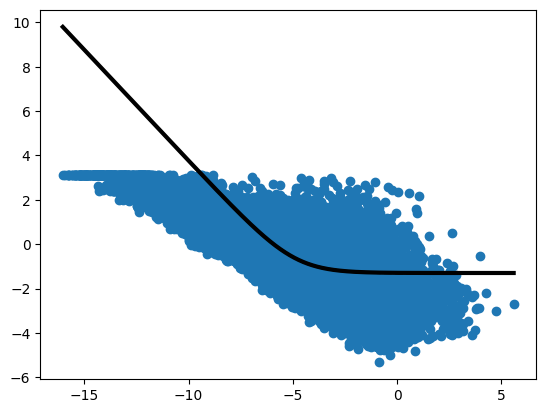

In [47]:
highvar_ref_ct = estimate_variability(np.exp(avg_expr_ref_ct)-1, do_plot = True)

In [48]:
highvar_ref_ct.index = shared_features
highvar_ref_ct.loc[['FOXG1','EMX1','DLX2','LHX5','LHX9','OTX2','EN1','TFAP2A','HOXB2','SLC32A1','SLC17A6'],:]

mean       var        cv2  useForFit  pval  padj
FOXG1    0.255868  0.806847  12.324189       True   0.0   0.0
EMX1     0.041557  0.034252  19.833767       True   0.0   0.0
DLX2     0.144552  0.147994   7.082690       True   0.0   0.0
LHX5     0.575749  0.342699   1.033826       True   0.0   0.0
LHX9     0.451941  0.847162   4.147666       True   0.0   0.0
OTX2     0.137052  0.153817   8.189107       True   0.0   0.0
EN1      0.377071  0.554614   3.900710       True   0.0   0.0
TFAP2A   0.393758  0.609752   3.932730       True   0.0   0.0
HOXB2    0.263855  0.251770   3.616369       True   0.0   0.0
SLC32A1  0.228795  0.050991   0.974094       True   0.0   0.0
SLC17A6  0.400397  0.182255   1.136837       True   0.0   0.0

In [49]:
hvg_ref_ct = highvar_ref_ct.index[np.where(highvar_ref_ct.padj < 0.01)[0]]
len(hvg_ref_ct)

3047

In [50]:
avg_expr_ref_ct_highvar = np.array(pd.DataFrame(avg_expr_ref_ct).set_axis(shared_features, axis=1)[hvg_ref_ct])
avg_expr_ref_ct_highvar.shape

(24, 3047)

### Average expression of organoid cell types per data set

In [51]:
avg_expr_bo_ct_ds = [ np.array([ np.array(adata_bo[(adata_bo.obs.annot_level_4_rev2 == x) & (adata_bo.obs.publication_protocol == ds),hvg_ref_ct].X.mean(0)).flatten() if np.sum((adata_bo.obs.annot_level_4_rev2 == x) & (adata_bo.obs.publication_protocol == ds)) > 20 else np.repeat(-1, len(hvg_ref_ct)) for x in ct2check]) for ds in adata_bo.obs.publication_protocol.cat.categories ]

### Spearman correlation

In [52]:
from scipy.stats import spearmanr
scor_highvar_ct_ds = np.array([ np.apply_along_axis(lambda i: spearmanr(avg_expr_ref_ct_highvar[i[0],:], avg_bo[i[0],:]).correlation if np.sum(avg_bo[i[0],:] < 0)==0 else np.nan, 1, np.arange(avg_expr_ref_ct_highvar.shape[0])[:,None]) for avg_bo in avg_expr_bo_ct_ds ])
scor_highvar_ct_ds.shape

(36, 24)

In [53]:
idx_ct_ordered = [5,23,7,6,19,18,4,3,22,20,2,0,12,9,17,14]

In [54]:
idx_datasets_ordered = [14,11,12,25,30,33,20,15,32,4,31,19,6,16,26,35,29,7,22,2,3,
                        5,18,24,13,34,8,9,10,27,28,23,0,1,21,17]

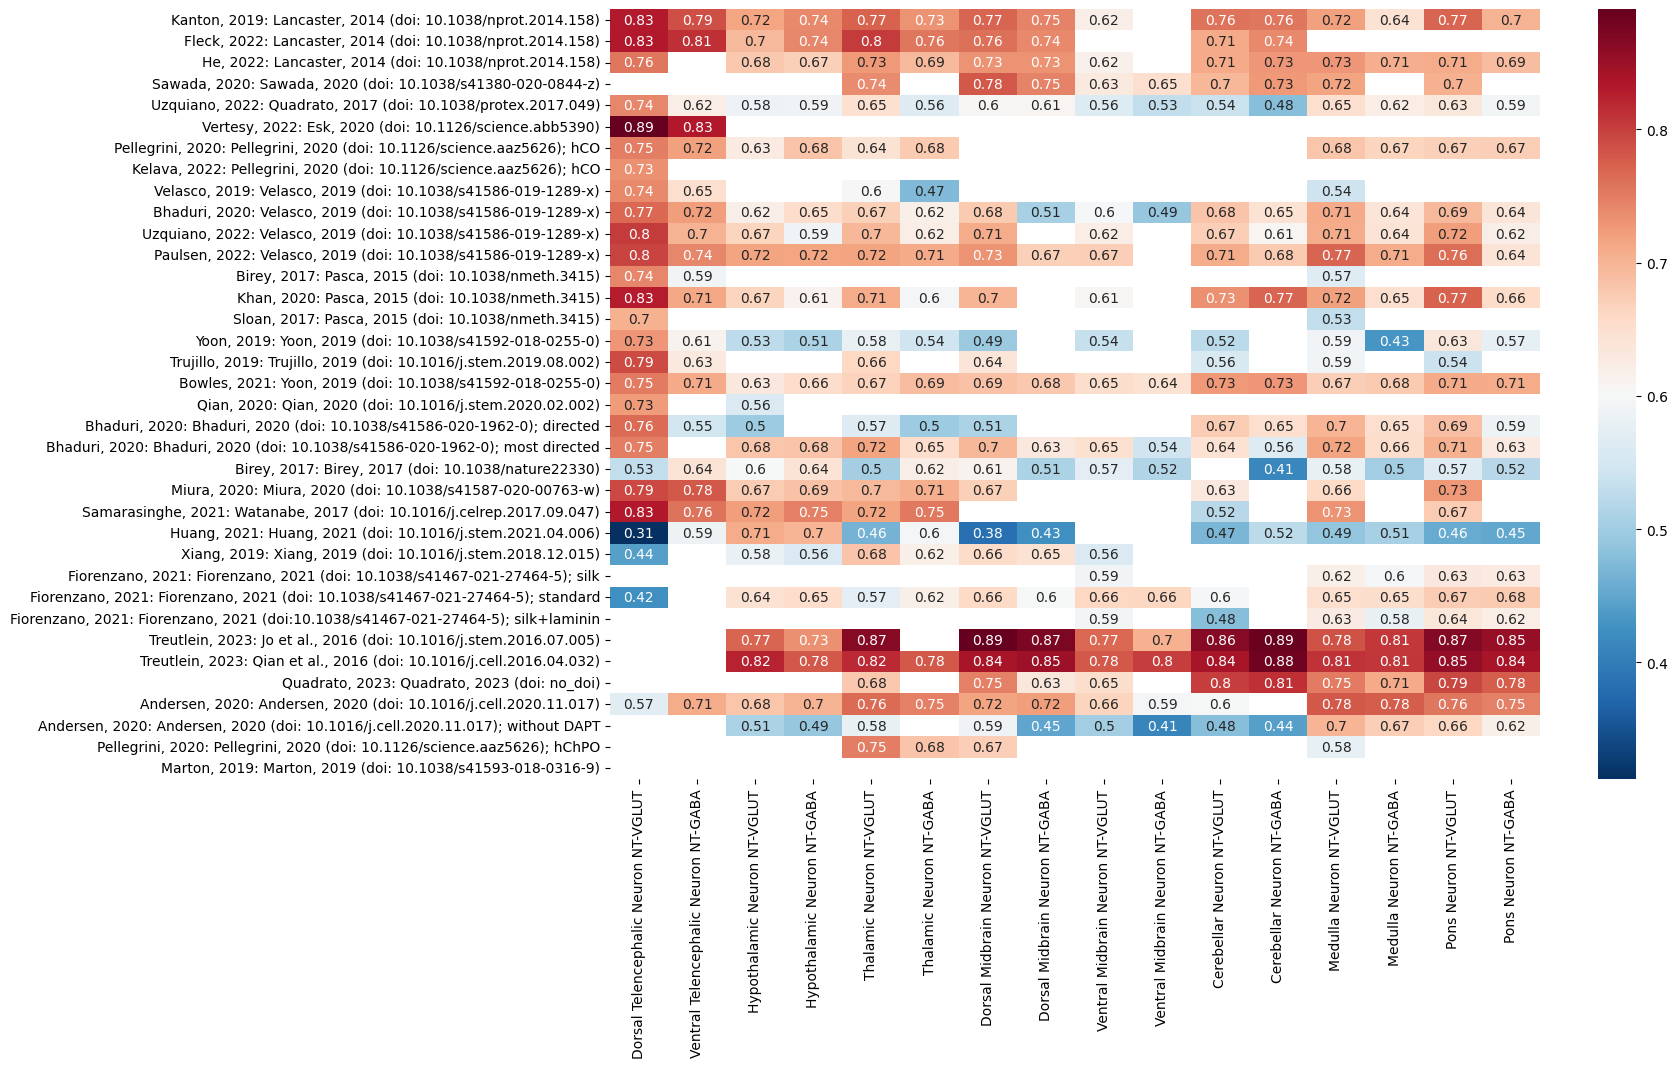

In [55]:
import seaborn as sns
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (15, 10)}):
    sns.heatmap(pd.DataFrame(scor_highvar_ct_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered], annot=True, cmap='RdBu_r', fmt='.02')

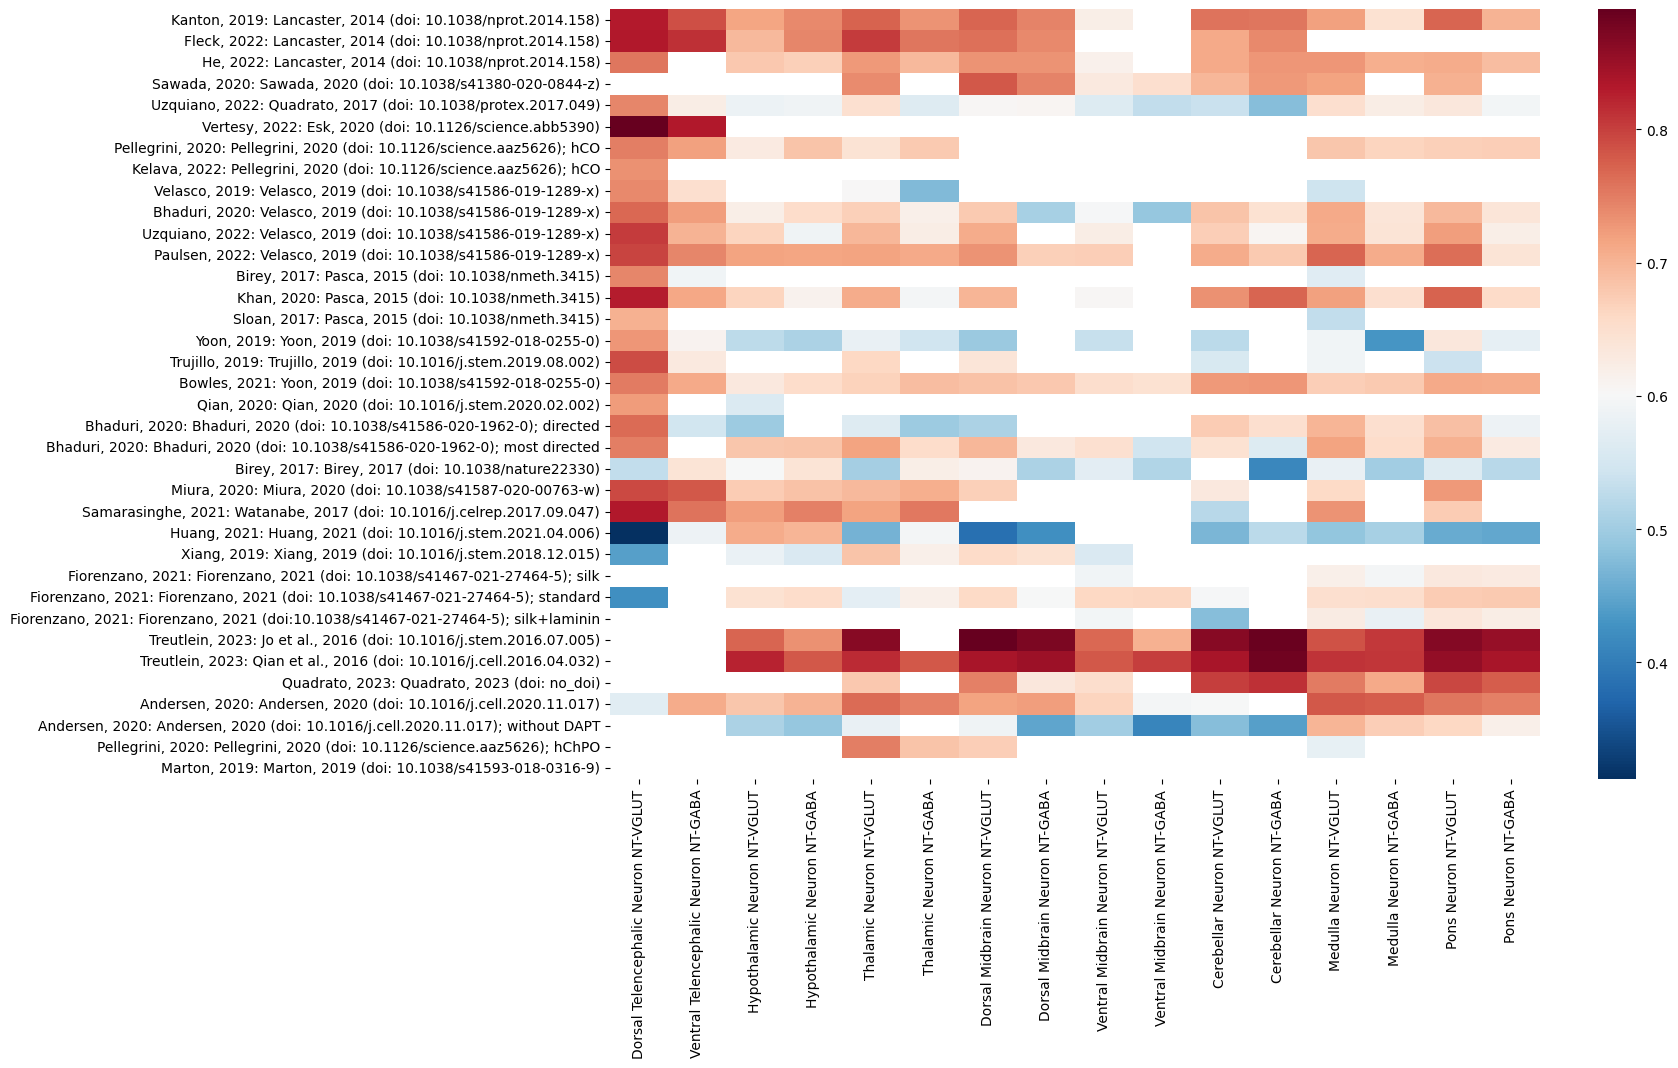

In [56]:
import seaborn as sns
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (15, 10)}):
    sns.heatmap(pd.DataFrame(scor_highvar_ct_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered], annot=False, cmap='RdBu_r', fmt='.02')
    plt.savefig('plots/revision/heatmap_scorr2ref_neurons.pdf')

### Spearman correlation over TF only

In [57]:
TFs = pd.read_csv('/links/groups/treutlein/USERS/zhisong_he/Work/databases/animalTFDB/animalTFDB_V4/Homo_sapiens_TF.txt', sep='\t')
hvg_TF_ref_ct = np.intersect1d(np.array(hvg_ref_ct), TFs['Symbol'][np.logical_not(TFs['Symbol'].isna())])
idx_TF_in_hvg = np.where(np.isin(hvg_ref_ct, hvg_TF_ref_ct))[0]
len(hvg_TF_ref_ct)

366

In [58]:
from scipy.stats import spearmanr
scor_highvar_TF_ct_ds = np.array([ np.apply_along_axis(lambda i: spearmanr(avg_expr_ref_ct_highvar[i[0],idx_TF_in_hvg], avg_bo[i[0],idx_TF_in_hvg]).correlation if np.sum(avg_bo[i[0],idx_TF_in_hvg] < 0)==0 else np.nan, 1, np.arange(avg_expr_ref_ct_highvar.shape[0])[:,None]) for avg_bo in avg_expr_bo_ct_ds ])
scor_highvar_TF_ct_ds.shape

(36, 24)

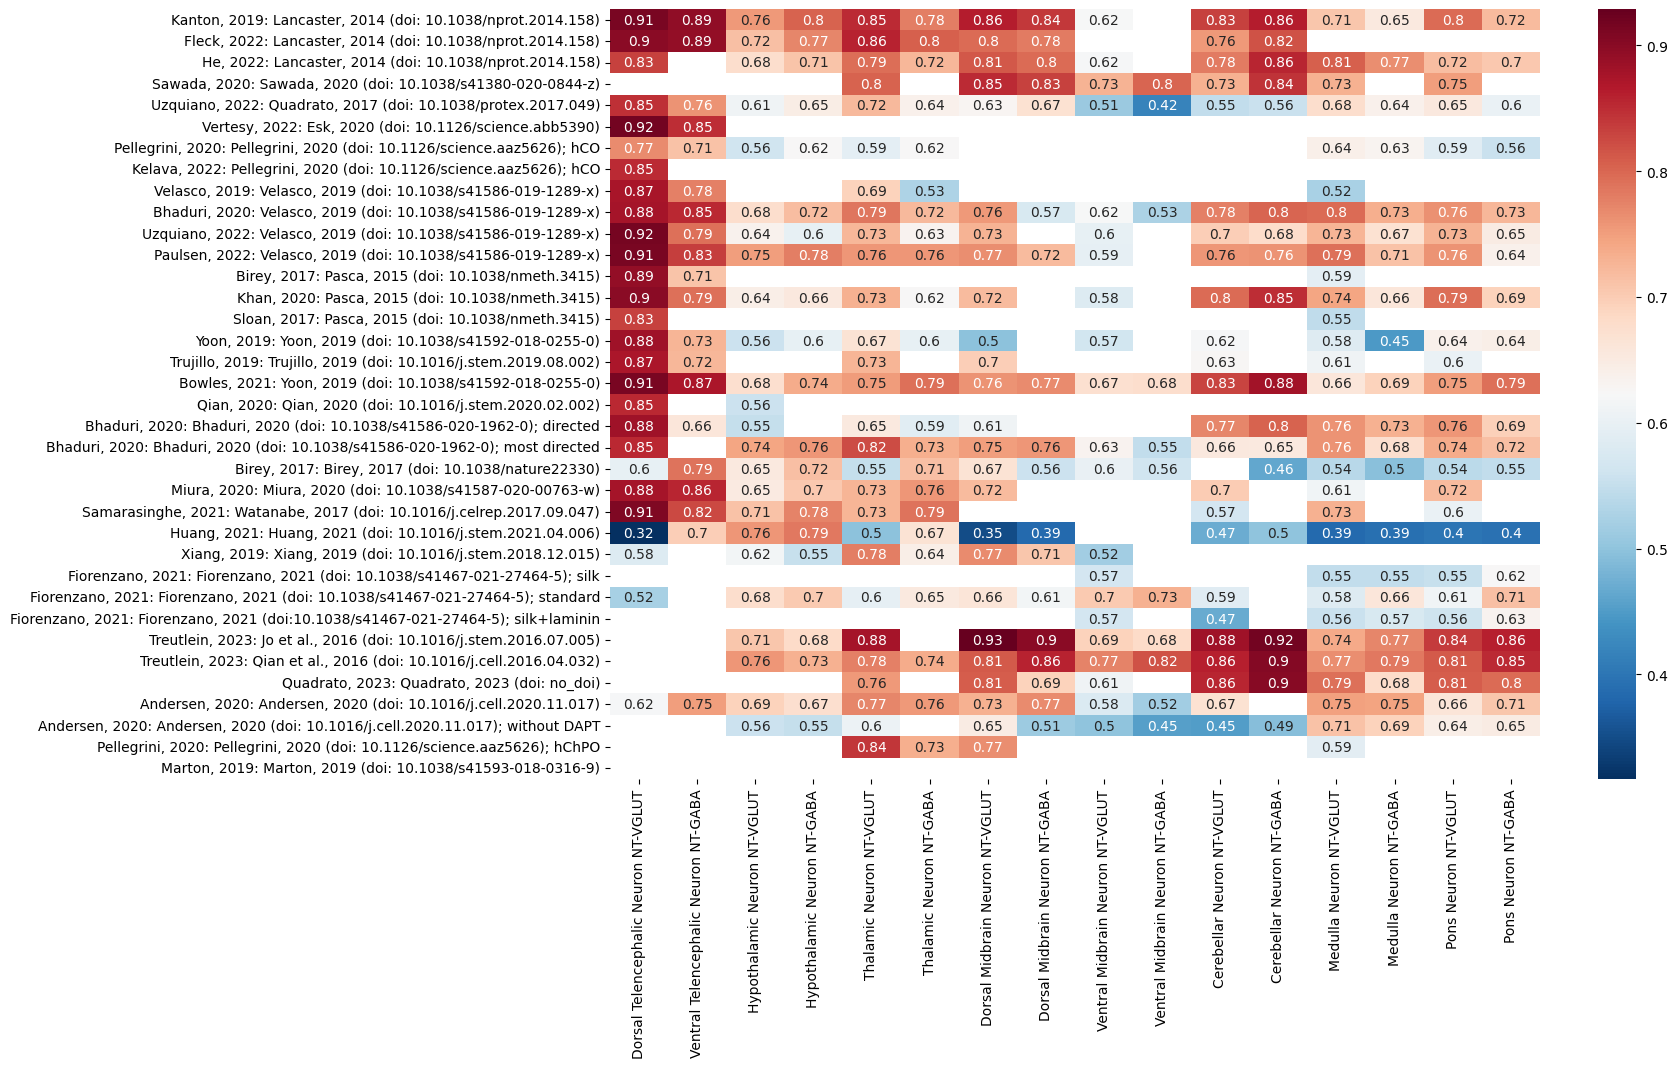

In [59]:
import seaborn as sns
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (15, 10)}):
    sns.heatmap(pd.DataFrame(scor_highvar_TF_ct_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered], annot=True, cmap='RdBu_r', fmt='.02')

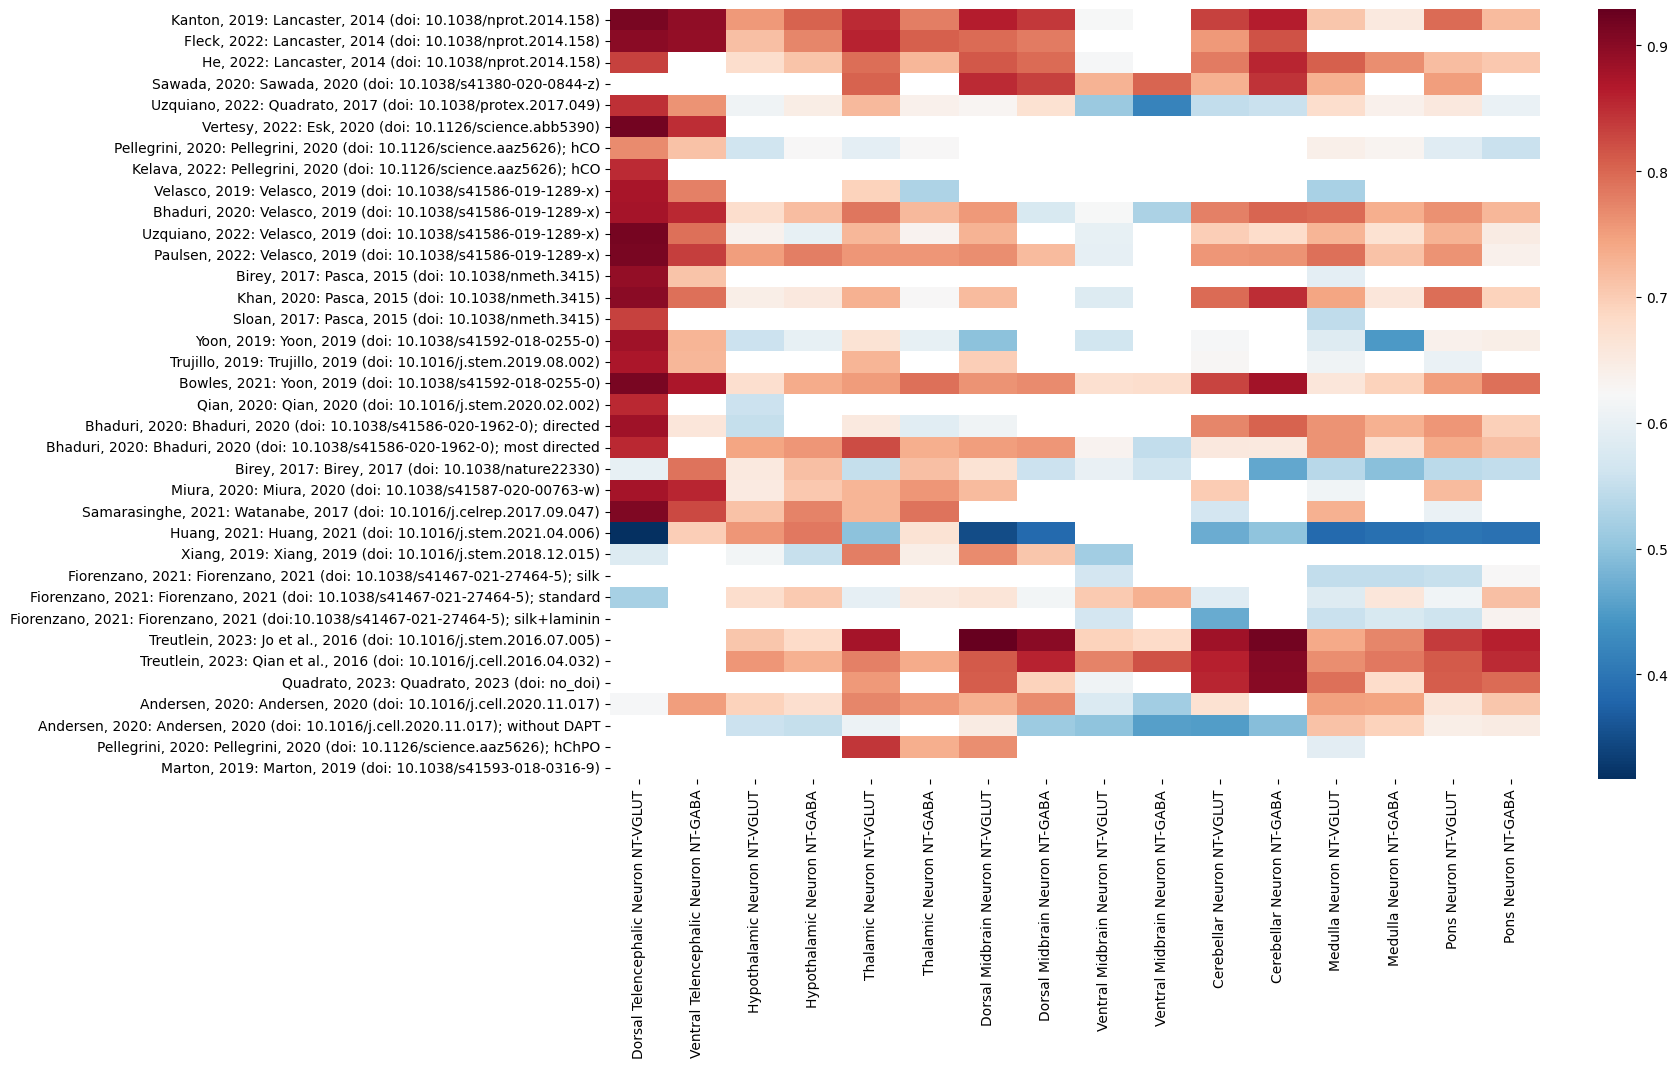

In [60]:
import seaborn as sns
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (15, 10)}):
    sns.heatmap(pd.DataFrame(scor_highvar_TF_ct_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered], annot=False, cmap='RdBu_r', fmt='.02')
    plt.savefig('plots/revision/heatmap_scorr2ref_neurons_TF-only.pdf')

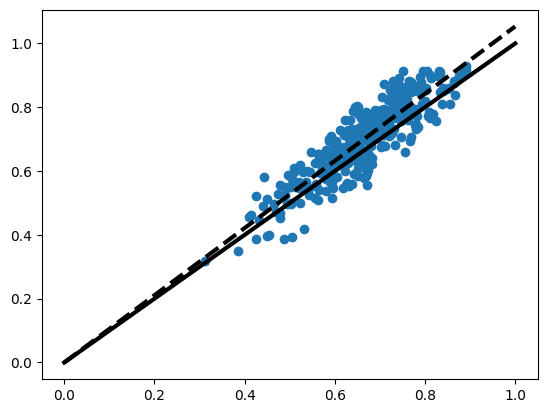

In [138]:
from sklearn.linear_model import LinearRegression

x = np.array(pd.DataFrame(scor_highvar_ct_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered]).flatten()
y = np.array(pd.DataFrame(scor_highvar_TF_ct_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered]).flatten()
plt.scatter(x, y)
m = LinearRegression(fit_intercept = False).fit(x[np.logical_not(np.isnan(x)),None], y[np.logical_not(np.isnan(x))])
plt.plot([0,1], [0,1], color='black', linewidth=3)
plt.plot([0,1], m.predict(np.array([[0],[1]])), '--', color='black', linewidth=3)
plt.savefig('plots/revision/scatter_sim_all_vs_TF.pdf')
plt.show()

In [141]:
m.coef_

array([1.05321337])

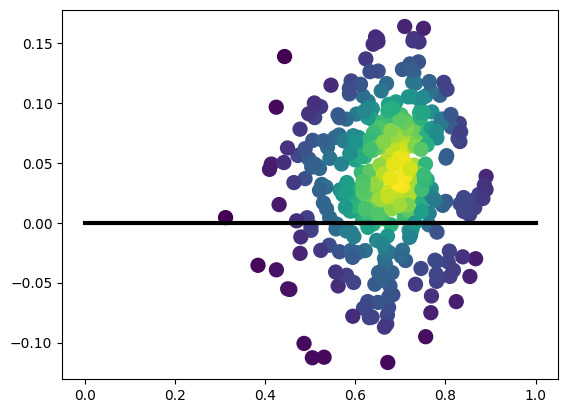

In [135]:
from scipy.stats import gaussian_kde

x = np.array(pd.DataFrame(scor_highvar_ct_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered]).flatten()
y = np.array(pd.DataFrame(scor_highvar_TF_ct_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered]).flatten()
y = y-x
x = x[np.logical_not(np.isnan(y))]
y = y[np.logical_not(np.isnan(y))]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
plt.scatter(x, y, c=z, s=100)
plt.plot([0,1], [0,0], color='black', linewidth=3)
plt.savefig('plots/revision/scatter_sim2sim_all_vs_TF_norm_density.pdf')
plt.show()

In [137]:
pd.Series(z).describe()

count    361.000000
mean      14.221147
std        7.899845
min        0.587267
25%        6.934813
50%       13.709784
75%       21.057578
max       28.631591
dtype: float64

### Spearman correlation over randomly selected highvar with the same size as TF numbers

In [92]:
hvg_ref_ct_rand = [ np.random.choice(hvg_ref_ct, len(hvg_TF_ref_ct), replace = False) for i in range(100) ]

In [93]:
idx_rand_in_hvg = [ np.where(np.isin(hvg_ref_ct, x))[0] for x in hvg_ref_ct_rand ]

In [94]:
from scipy.stats import spearmanr
scor_highvar_rand_ct_ds = [ np.array([ np.apply_along_axis(lambda i: spearmanr(avg_expr_ref_ct_highvar[i[0],idx], avg_bo[i[0],idx]).correlation if np.sum(avg_bo[i[0],idx] < 0)==0 else np.nan, 1, np.arange(avg_expr_ref_ct_highvar.shape[0])[:,None]) for avg_bo in avg_expr_bo_ct_ds ])
                           for idx in idx_rand_in_hvg]
len(scor_highvar_rand_ct_ds)

100

# Overall Spearman correlation between organoid cell types and reference counterparts, with stressed cells filtered

## Load stress scores and do filtering

In [62]:
stress_scores = pd.read_csv('data/phase3_final_0516/DE_240528/obs_stress_scores_revision.tsv.gz', sep='\t', index_col = 0)
stress_scores.head()

assay_sc  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  BD Rhapsody Whole Transcriptome Analysis   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  BD Rhapsody Whole Transcriptome Analysis   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  BD Rhapsody Whole Transcriptome Analysis   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  BD Rhapsody Whole Transcriptome Analysis   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  BD Rhapsody Whole Transcriptome Analysis   

                                                                               assay_differentiation  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)   

                                                   assay_type_differentiation  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...                     guided   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...                     guided   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...                     guided   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...                     guided   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...                     guided   

                                                        cell_line  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  custom_8858-1   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  custom_8858-1   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  custom_8858-1   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  custom_8858-1   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  custom_8858-1   

                                                   suspension_type  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...            cell   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...            cell   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...            cell   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...            cell   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...            cell   

                                                    organoid_age_days  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...               45.0   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...               45.0   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...               45.0   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...               45.0   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...               45.0   

                                                       publication  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020   

                                                                                                batch  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  homosapiens_hindbrain_2020_bdrhapsodywholetran...   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  homosapiens_hindbrain_2020_bdrhapsodywholetran...   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  homosapiens_hindbrain_2020_bdrhapsodywholetran...   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  homosapiens_hindbrain_2020_bdrhapsodywholetran...   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  homosapiens_hindbrain_2020_bdrhapsodywholetran...   

                                                    n_genes  \
homos

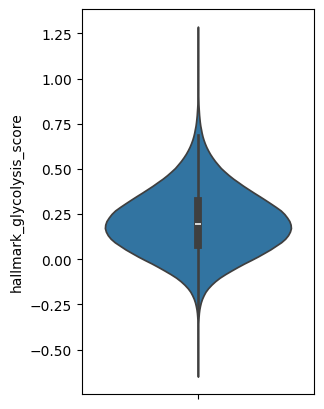

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
with plt.rc_context({'figure.figsize' : (3,5)}):
    sns.violinplot(stress_scores.hallmark_glycolysis_score)

In [73]:
unstressed_cells = stress_scores.index[stress_scores.hallmark_glycolysis_score < 0.3]
unstressed_cells

Index(['homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_79',
       'homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_85',
       'homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_94',
       'homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_131',
       'homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_135',
       'homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_139',
       'homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_142',
       'homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_146',
   

In [74]:
len(np.intersect1d(adata_ref.obs_names, unstressed_cells))

688297

In [75]:
len(np.intersect1d(adata_bo.obs_names, unstressed_cells))

519277

In [76]:
shared_features = np.intersect1d(adata_ref.var_names, adata_bo.var_names)
len(shared_features)

22198

In [78]:
ct2check = np.intersect1d(adata_ref.obs['CellType2'].cat.categories, adata_bo.obs.annot_level_4_rev2.cat.categories)
ct2check

array(['Cerebellar Neuron NT-GABA', 'Cerebellar Neuron NT-GLY',
       'Cerebellar Neuron NT-VGLUT', 'Dorsal Midbrain Neuron NT-GABA',
       'Dorsal Midbrain Neuron NT-VGLUT',
       'Dorsal Telencephalic Neuron NT-VGLUT',
       'Hypothalamic Neuron NT-GABA', 'Hypothalamic Neuron NT-VGLUT',
       'Medulla Neuron NT-CHOL', 'Medulla Neuron NT-GABA',
       'Medulla Neuron NT-GLY', 'Medulla Neuron NT-SER',
       'Medulla Neuron NT-VGLUT', 'Pons Neuron NT-CHOL',
       'Pons Neuron NT-GABA', 'Pons Neuron NT-GLY', 'Pons Neuron NT-SER',
       'Pons Neuron NT-VGLUT', 'Thalamic Neuron NT-GABA',
       'Thalamic Neuron NT-VGLUT', 'Ventral Midbrain Neuron NT-GABA',
       'Ventral Midbrain Neuron NT-GLY',
       'Ventral Midbrain Neuron NT-VGLUT',
       'Ventral Telencephalic Neuron NT-GABA'], dtype=object)

## Average expression of reference and highly variable TFs identification

In [112]:
adata_ref_unstressed = adata_ref[np.intersect1d(adata_ref.obs_names, unstressed_cells),shared_features]
avg_expr_ref_ct2 = np.array([ np.array(adata_ref_unstressed[adata_ref_unstressed.obs['CellType2'] == x,:].X.mean(0)).flatten() for x in ct2check ])
avg_expr_ref_ct2.shape

(24, 22198)

/local1/scratch/hezhi/temp/ipykernel_82834/951913849.py:10: RuntimeWarning: invalid value encountered in divide
  cv2 = variance / (means ** 2)
/links/groups/treutlein/USERS/zhisong_he/miniconda3/envs/env_scg2/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/links/groups/treutlein/USERS/zhisong_he/miniconda3/envs/env_scg2/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/local1/scratch/hezhi/temp/ipykernel_82834/951913849.py:26: RuntimeWarning: divide by zero encountered in divide
  afit = a1 / means + a0
/local1/scratch/hezhi/temp/ipykernel_82834/951913849.py:27: RuntimeWarning: invalid value encountered in multiply
  var

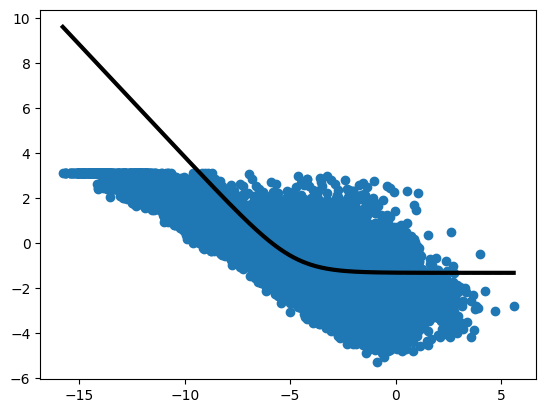

In [113]:
highvar_ref_ct2 = estimate_variability(np.exp(avg_expr_ref_ct2)-1, do_plot = True)

In [114]:
highvar_ref_ct2.index = shared_features

In [115]:
hvg_ref_ct2 = highvar_ref_ct2.index[np.where(highvar_ref_ct2.padj < 0.01)[0]]
len(hvg_ref_ct2)

2997

In [116]:
TFs = pd.read_csv('/links/groups/treutlein/USERS/zhisong_he/Work/databases/animalTFDB/animalTFDB_V4/Homo_sapiens_TF.txt', sep='\t')
hvg_TF_ref_ct2 = np.intersect1d(np.array(hvg_ref_ct2), TFs['Symbol'][np.logical_not(TFs['Symbol'].isna())])
len(hvg_TF_ref_ct2)

367

In [117]:
[len(np.intersect1d(hvg_TF_ref_ct2, hvg_TF_ref_ct)), len(np.intersect1d(hvg_ref_ct2, hvg_ref_ct))]

[358, 2868]

In [118]:
#genes2use = hvg_ref_ct2 # use unstress-only highvar
#genes2use = hvg_TF_ref_ct2 # use unstress-only highvar TF subset
#genes2use = hvg_ref_ct # use all highvar
genes2use = hvg_TF_ref_ct # use all highvar TF subset

In [119]:
avg_expr_ref_ct2_highvar = np.array(pd.DataFrame(avg_expr_ref_ct2).set_axis(shared_features, axis=1)[genes2use])
avg_expr_ref_ct2_highvar.shape

(24, 366)

## Average expression of organoid neuron subtypes after stress filtering

In [120]:
adata_bo_unstressed = adata_bo[np.intersect1d(adata_bo.obs_names, unstressed_cells),:]

In [121]:
avg_expr_bo_ct2_ds = [ np.array([ np.array(adata_bo_unstressed[(adata_bo_unstressed.obs.annot_level_4_rev2 == x) & (adata_bo_unstressed.obs.publication_protocol == ds),genes2use].X.mean(0)).flatten()
                                 if np.sum((adata_bo_unstressed.obs.annot_level_4_rev2 == x) & (adata_bo_unstressed.obs.publication_protocol == ds)) > 20 else np.repeat(-1, len(genes2use))
                                 for x in ct2check]) for ds in adata_bo_unstressed.obs.publication_protocol.cat.categories ]

## Spearman correlation

In [122]:
from scipy.stats import spearmanr
scor_highvar_ct2_ds = np.array([ np.apply_along_axis(lambda i: spearmanr(avg_expr_ref_ct2_highvar[i[0],:], avg_bo[i[0],:]).correlation if np.sum(avg_bo[i[0],:] < 0)==0 else np.nan, 1, np.arange(avg_expr_ref_ct2_highvar.shape[0])[:,None]) for avg_bo in avg_expr_bo_ct2_ds ])
scor_highvar_ct2_ds.shape

(36, 24)

In [123]:
idx_ct_ordered = [5,23,7,6,19,18,4,3,22,20,2,0,12,9,17,14]

In [124]:
idx_datasets_ordered = [14,11,12,25,30,33,20,15,32,4,31,19,6,16,26,29,35,7,22,2,3,5,18,24,13,34,8,9,10,27,28,23,0,1,21,17]

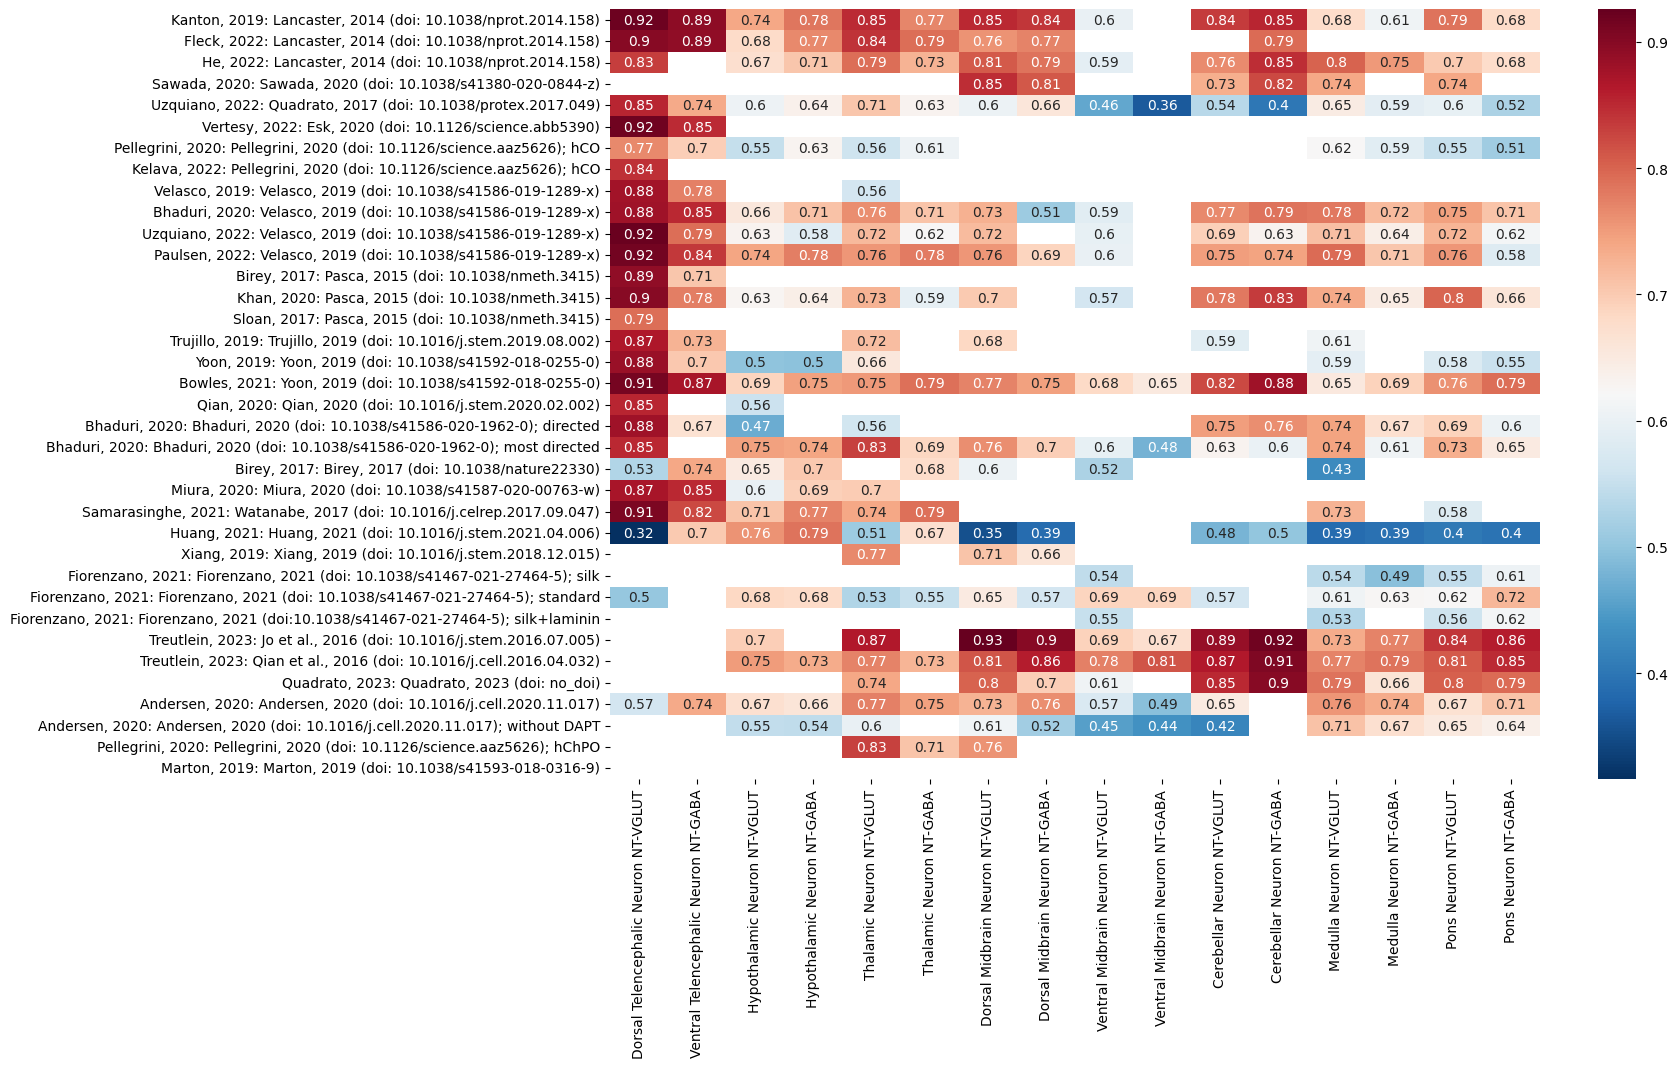

In [125]:
import seaborn as sns
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (15, 10)}):
    sns.heatmap(pd.DataFrame(scor_highvar_ct2_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered], annot=True, cmap='RdBu_r', fmt='.02')

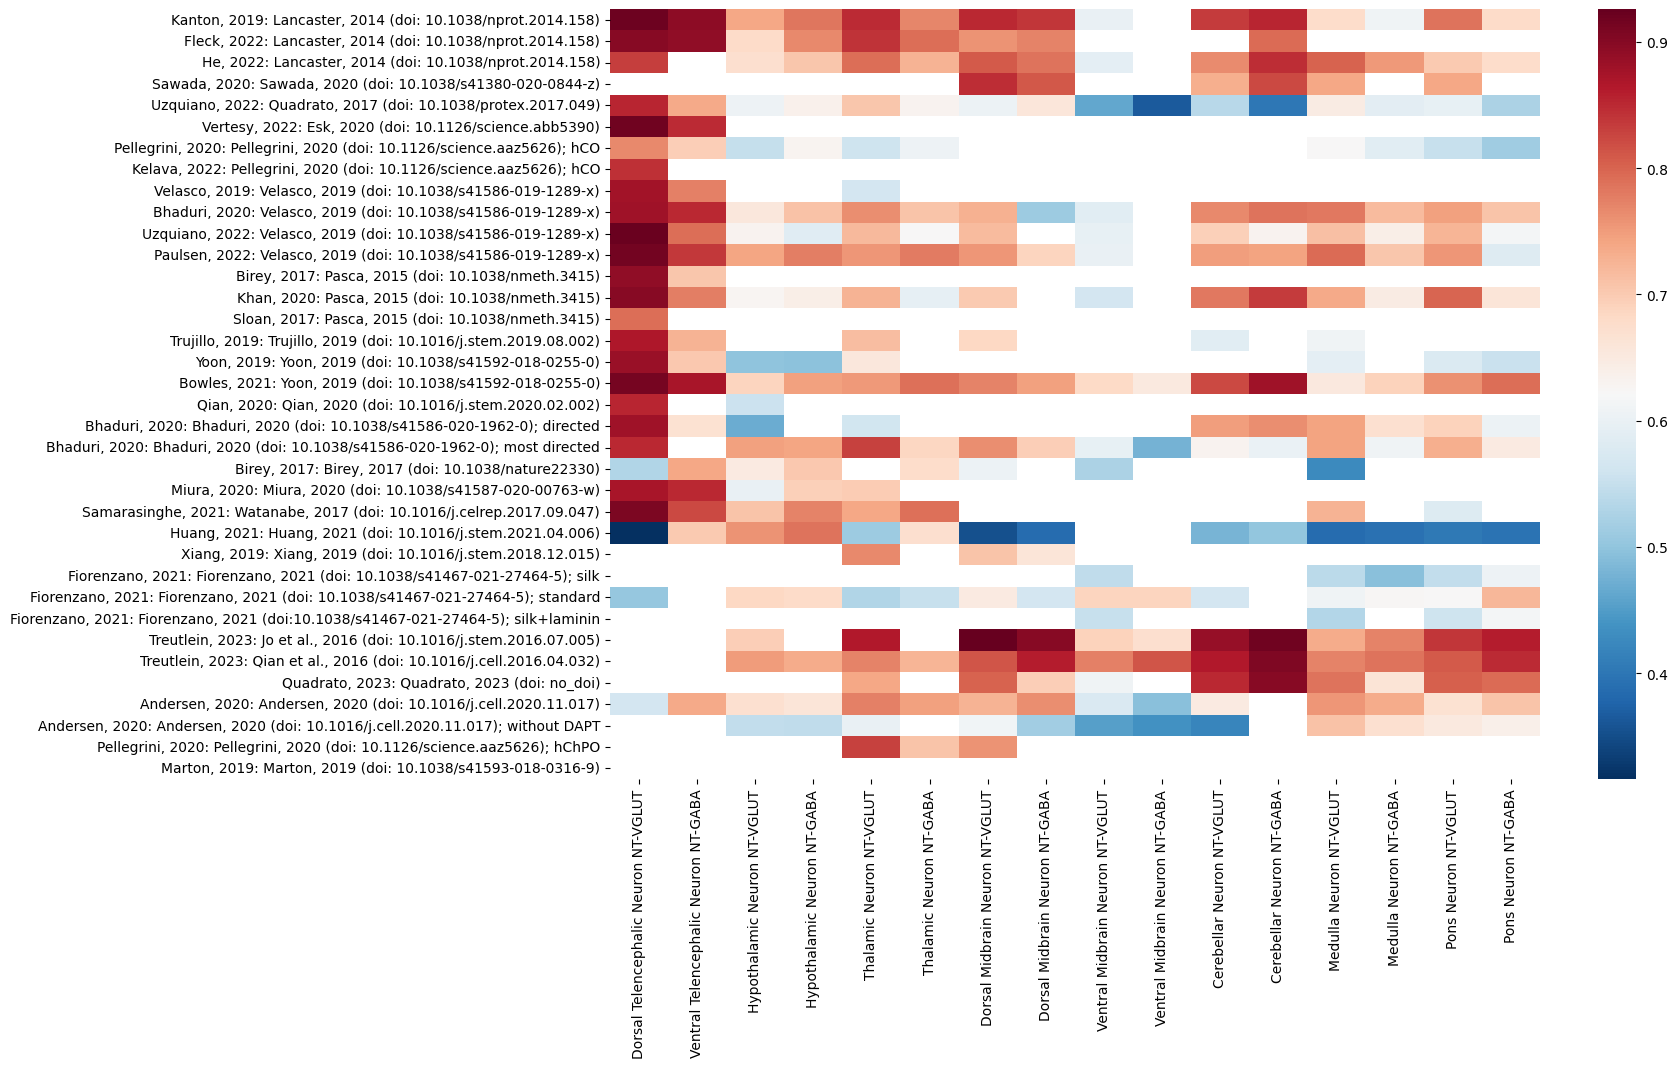

In [126]:
import seaborn as sns
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (15, 10)}):
    sns.heatmap(pd.DataFrame(scor_highvar_ct2_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered], annot=False, cmap='RdBu_r', fmt='.02')
    plt.savefig('plots/revision/heatmap_scorr2ref_neurons_glycolysis_filtered_TF-only.pdf')

In [127]:
pd.DataFrame(scor_highvar_ct2_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered].shape

(36, 16)

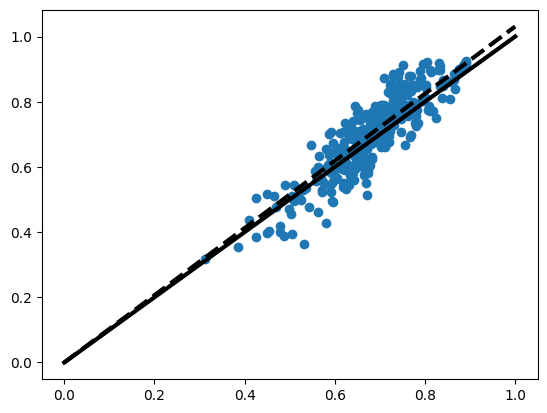

In [128]:
from sklearn.linear_model import LinearRegression

x = np.array(pd.DataFrame(scor_highvar_ct_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered]).flatten()
y = np.array(pd.DataFrame(scor_highvar_ct2_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered]).flatten()
plt.scatter(x, y)
m = LinearRegression(fit_intercept = False).fit(x[np.logical_not(np.isnan(x)) & np.logical_not(np.isnan(y)),None], y[np.logical_not(np.isnan(x)) & np.logical_not(np.isnan(y))])
plt.plot([0,1], [0,1], color='black', linewidth=3)
plt.plot([0,1], m.predict(np.array([[0],[1]])), '--', color='black', linewidth=3)
plt.savefig('plots/phase3_final_0516/scatter_sim2sim_all_vs_TF.pdf')
plt.show()

In [97]:
m.coef_

array([1.04085912])

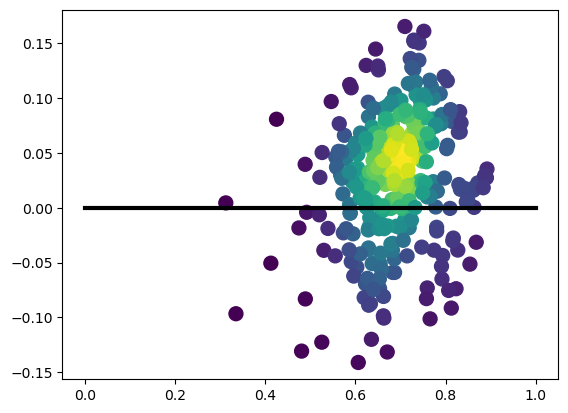

In [127]:
from scipy.stats import gaussian_kde

x = np.array(pd.DataFrame(scor_highvar_ct_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered]).flatten()
y = np.array(pd.DataFrame(scor_highvar_ct2_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered]).flatten()
y = y-x
x = x[np.logical_not(np.isnan(y))]
y = y[np.logical_not(np.isnan(y))]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
plt.scatter(x, y, c=z, s=100)
plt.plot([0,1], [0,0], color='black', linewidth=3)
plt.savefig('plots/revision/scatter_sim2sim_all_vs_TF_norm_density.pdf')
plt.show()

In [128]:
[np.min(z), np.max(z)]

[0.6785546308281988, 33.652153903682425]

In [136]:
from scipy.stats import ranksums
from scipy.stats import wilcoxon

x = np.array(pd.DataFrame(scor_highvar_ct_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered]).flatten()
y = np.array(pd.DataFrame(scor_highvar_ct2_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered]).flatten()
idx = np.logical_not(np.isnan(x)) & np.logical_not(np.isnan(y))
x = x[idx]
y = y[idx]
[ ranksums(x, y, alternative = 'two-sided'),
 wilcoxon(x,y, alternative = 'two-sided') ]

[RanksumsResult(statistic=-3.8059546180699915, pvalue=0.0001412582846113122),
 WilcoxonResult(statistic=11922.0, pvalue=1.9982849925116636e-14)]

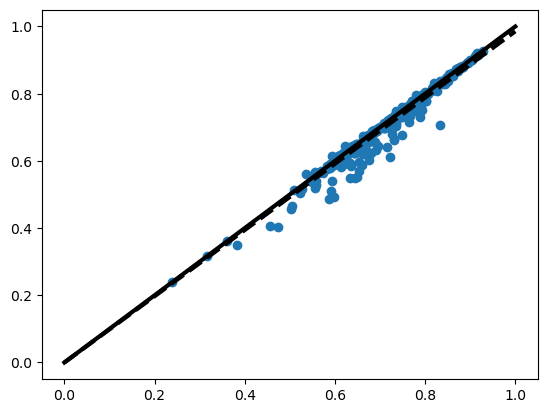

In [98]:
from sklearn.linear_model import LinearRegression

x = np.array(pd.DataFrame(scor_highvar_TF_ct_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered]).flatten()
y = np.array(pd.DataFrame(scor_highvar_ct2_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered]).flatten()
plt.scatter(x, y)
m = LinearRegression(fit_intercept = False).fit(x[np.logical_not(np.isnan(x)) & np.logical_not(np.isnan(y)),None], y[np.logical_not(np.isnan(x)) & np.logical_not(np.isnan(y))])
plt.plot([0,1], [0,1], color='black', linewidth=3)
plt.plot([0,1], m.predict(np.array([[0],[1]])), '--', color='black', linewidth=3)
plt.savefig('plots/phase3_final_0516/scatter_sim2sim_TF_vs_TFf.pdf')
plt.show()

In [99]:
m.coef_

array([0.9855393])

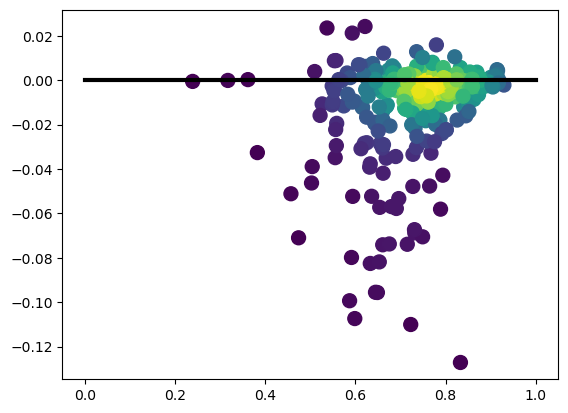

In [131]:
x = np.array(pd.DataFrame(scor_highvar_TF_ct_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered]).flatten()
y = np.array(pd.DataFrame(scor_highvar_ct2_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered]).flatten()
y = y-x
x = x[np.logical_not(np.isnan(y))]
y = y[np.logical_not(np.isnan(y))]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
plt.scatter(x, y, c=z, s=100)
plt.plot([0,1], [0,0], color='black', linewidth=3)
plt.savefig('plots/phase3_final_0516/scatter_sim2sim_TF_vs_TFf_norm_density.pdf')
plt.show()

In [132]:
[np.min(z), np.max(z)]

[1.464361545542597, 113.66209080581429]

In [135]:
from scipy.stats import ranksums
from scipy.stats import wilcoxon

x = np.array(pd.DataFrame(scor_highvar_TF_ct_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered]).flatten()
y = np.array(pd.DataFrame(scor_highvar_ct2_ds, index=adata_bo.obs.publication_protocol.cat.categories).set_axis(ct2check, axis=1).iloc[idx_datasets_ordered,idx_ct_ordered]).flatten()
idx = np.logical_not(np.isnan(x)) & np.logical_not(np.isnan(y))
x = x[idx]
y = y[idx]
[ ranksums(x, y, alternative = 'two-sided'),
 wilcoxon(x,y, alternative = 'two-sided') ]

[RanksumsResult(statistic=1.231252115536169, pvalue=0.21822858509856657),
 WilcoxonResult(statistic=8710.0, pvalue=3.18992525878344e-22)]

# Stress scores per cell

In [79]:
stress_scores = pd.read_csv('data/phase3_final_0516/DE_240528/obs_stress_scores_revision.tsv.gz', sep='\t', index_col = 0)
stress_scores.head()

assay_sc  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  BD Rhapsody Whole Transcriptome Analysis   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  BD Rhapsody Whole Transcriptome Analysis   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  BD Rhapsody Whole Transcriptome Analysis   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  BD Rhapsody Whole Transcriptome Analysis   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  BD Rhapsody Whole Transcriptome Analysis   

                                                                               assay_differentiation  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)   

                                                   assay_type_differentiation  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...                     guided   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...                     guided   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...                     guided   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...                     guided   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...                     guided   

                                                        cell_line  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  custom_8858-1   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  custom_8858-1   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  custom_8858-1   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  custom_8858-1   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  custom_8858-1   

                                                   suspension_type  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...            cell   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...            cell   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...            cell   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...            cell   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...            cell   

                                                    organoid_age_days  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...               45.0   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...               45.0   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...               45.0   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...               45.0   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...               45.0   

                                                       publication  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020   

                                                                                                batch  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  homosapiens_hindbrain_2020_bdrhapsodywholetran...   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  homosapiens_hindbrain_2020_bdrhapsodywholetran...   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  homosapiens_hindbrain_2020_bdrhapsodywholetran...   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  homosapiens_hindbrain_2020_bdrhapsodywholetran...   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  homosapiens_hindbrain_2020_bdrhapsodywholetran...   

                                                    n_genes  \
homos

In [80]:
stress_scores['publication_protocol'] = np.array([x.replace('_',': ').replace('no: doi','no_doi') for x in stress_scores.publication_protocol])
stress_scores.head()

assay_sc  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  BD Rhapsody Whole Transcriptome Analysis   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  BD Rhapsody Whole Transcriptome Analysis   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  BD Rhapsody Whole Transcriptome Analysis   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  BD Rhapsody Whole Transcriptome Analysis   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  BD Rhapsody Whole Transcriptome Analysis   

                                                                               assay_differentiation  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)   

                                                   assay_type_differentiation  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...                     guided   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...                     guided   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...                     guided   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...                     guided   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...                     guided   

                                                        cell_line  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  custom_8858-1   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  custom_8858-1   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  custom_8858-1   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  custom_8858-1   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  custom_8858-1   

                                                   suspension_type  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...            cell   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...            cell   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...            cell   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...            cell   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...            cell   

                                                    organoid_age_days  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...               45.0   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...               45.0   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...               45.0   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...               45.0   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...               45.0   

                                                       publication  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  Andersen, 2020   

                                                                                                batch  \
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  homosapiens_hindbrain_2020_bdrhapsodywholetran...   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  homosapiens_hindbrain_2020_bdrhapsodywholetran...   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  homosapiens_hindbrain_2020_bdrhapsodywholetran...   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  homosapiens_hindbrain_2020_bdrhapsodywholetran...   
homosapiens_hindbrain_2020_bdrhapsodywholetrans...  homosapiens_hindbrain_2020_bdrhapsodywholetran...   

                                                    n_genes  \
homos

In [81]:
neuron_subtypes = adata_bo.obs['annot_level_4_rev2'][adata_bo.obs['annot_level_1'] == 'Neuron'].cat.remove_unused_categories().cat.categories

In [83]:
avg_stress_score_ld = np.array([ np.array([ stress_scores.hallmark_glycolysis_score[(stress_scores.neuron_subtype == ct) & (stress_scores.publication_protocol == ds)].mean()
                                               for ct in neuron_subtypes[neuron_subtypes.str.match('.+NT\\-(VGLUT|GABA)')] ])
                                    for ds in adata_bo.obs.publication_protocol.cat.categories ])
avg_stress_score_ld.shape

(36, 16)

In [102]:
avg_stress2_score_ld = np.array([ np.array([ stress_scores.canonical_glycolysis_score[(stress_scores.neuron_subtype == ct) & (stress_scores.publication_protocol == ds)].mean()
                                               for ct in neuron_subtypes[neuron_subtypes.str.match('.+NT\\-(VGLUT|GABA)')] ])
                                    for ds in adata_bo.obs.publication_protocol.cat.categories ])
avg_stress2_score_ld.shape

(36, 16)

In [98]:
avg_electron_score_ld = np.array([ np.array([ stress_scores.mitochondrial_ATP_synthesis_coupled_electron_transport_score[(stress_scores.neuron_subtype == ct) & (stress_scores.publication_protocol == ds)].mean()
                                               for ct in neuron_subtypes[neuron_subtypes.str.match('.+NT\\-(VGLUT|GABA)')] ])
                                    for ds in adata_bo.obs.publication_protocol.cat.categories ])
avg_electron_score_ld.shape

(36, 16)

In [84]:
num_cells = np.array([np.array([np.sum((stress_scores.neuron_subtype == ct) & (stress_scores.publication_protocol == ds))
                                for ct in neuron_subtypes[neuron_subtypes.str.match('.+NT\\-(VGLUT|GABA)')] ])
                     for ds in adata_bo.obs.publication_protocol.cat.categories ])
num_cells.shape

(36, 16)

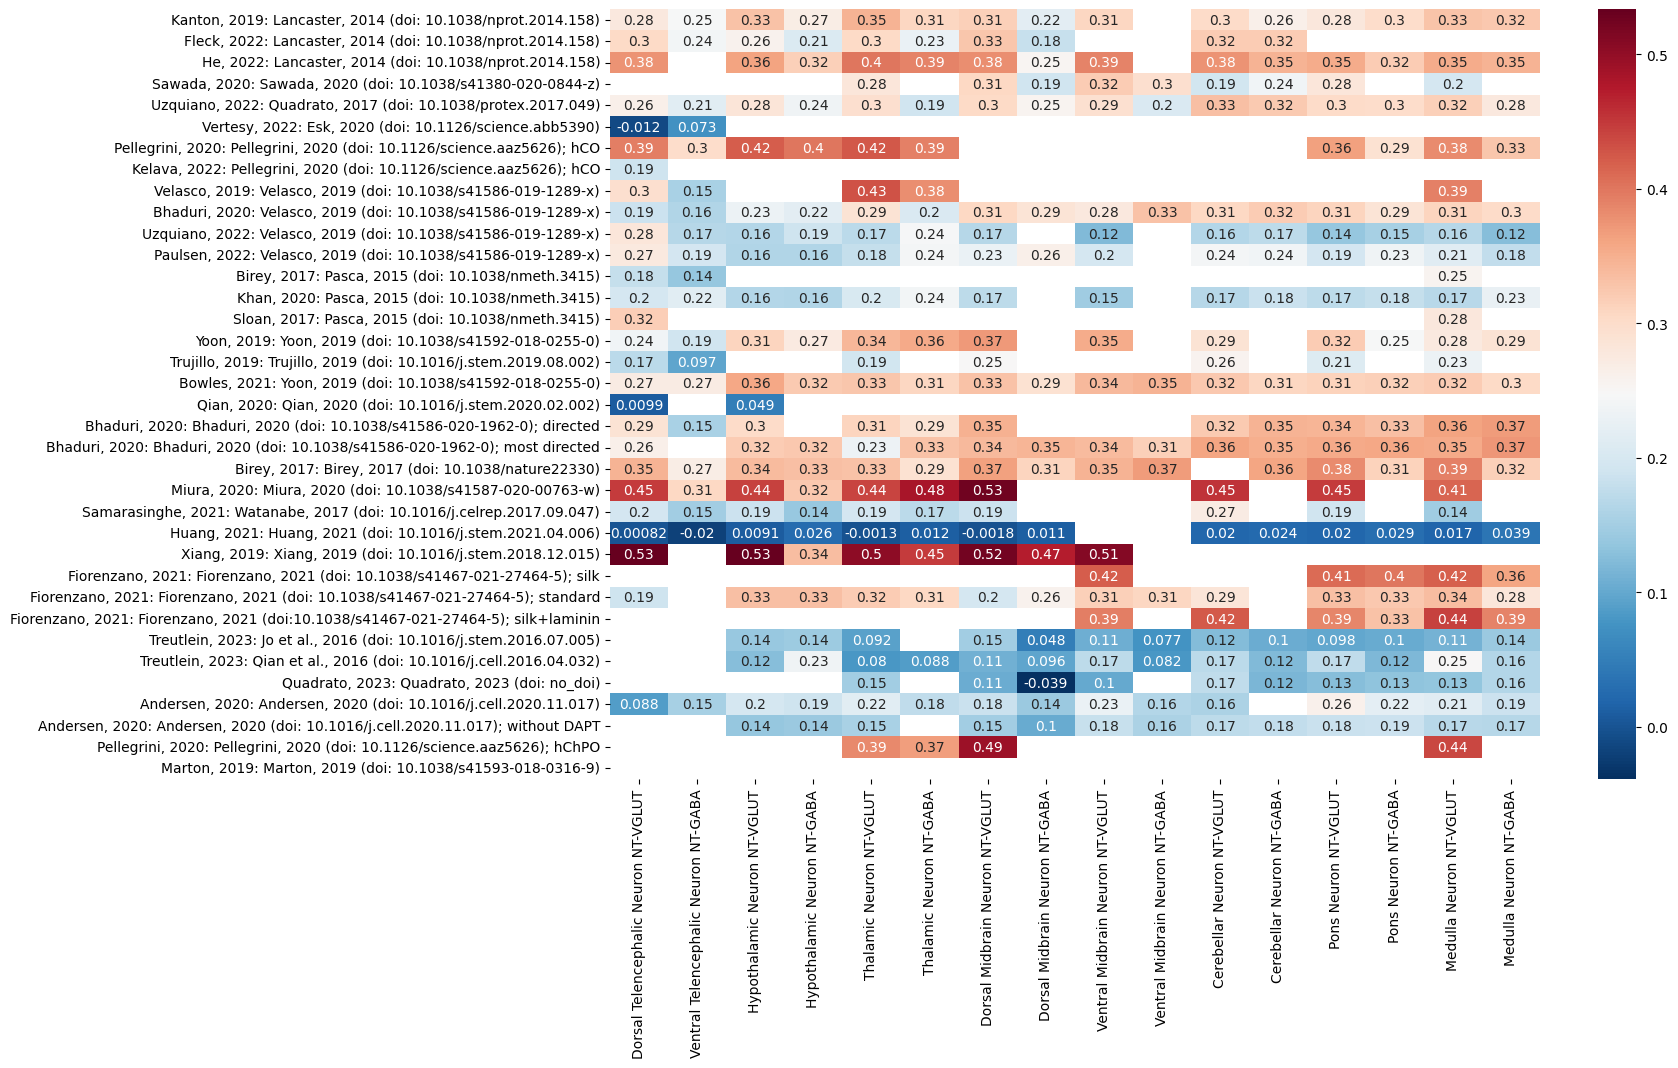

In [85]:
mat = avg_stress_score_ld
mat[num_cells < 20] = np.nan

import seaborn as sns
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (15, 10)}):
    sns.heatmap(pd.DataFrame(mat,
                             index=adata_bo.obs.publication_protocol.cat.categories).set_axis(neuron_subtypes[neuron_subtypes.str.match('.+NT\\-(VGLUT|GABA)')], axis=1).iloc[idx_datasets_ordered,:], annot=True, cmap='RdBu_r', fmt='.02')

In [86]:
scor_highvar_ct_ds[:,idx_ct_ordered].shape

(36, 16)

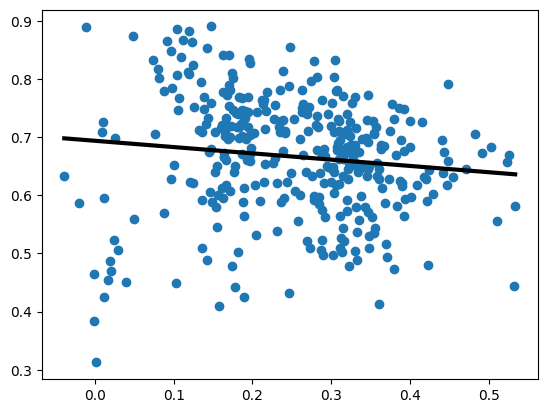

In [88]:
from sklearn.linear_model import LinearRegression
m = LinearRegression()
idx = np.logical_not((np.isnan(avg_stress_score_ld.flatten())) | (np.isnan(scor_highvar_ct_ds[:,idx_ct_ordered].flatten())))
m.fit(avg_stress_score_ld.flatten()[idx,None], scor_highvar_ct_ds[:,idx_ct_ordered].flatten()[idx])
pred_x = np.linspace(np.nanmin(avg_stress_score_ld.flatten()), np.nanmax(avg_stress_score_ld.flatten()), num=1000)[:,None]
pred_y = m.predict(pred_x)
plt.scatter(avg_stress_score_ld.flatten()[idx], scor_highvar_ct_ds[:,idx_ct_ordered].flatten()[idx])
plt.plot(pred_x, pred_y, color='black', linewidth=3)
plt.savefig('plots/revision/scatter_sim2glycolysis_ld_highvar.pdf')

In [89]:
from scipy.stats import pearsonr
pearsonr(avg_stress_score_ld.flatten()[idx], scor_highvar_ct_ds[:,idx_ct_ordered].flatten()[idx])

PearsonRResult(statistic=-0.12032974082917537, pvalue=0.022974531614430933)

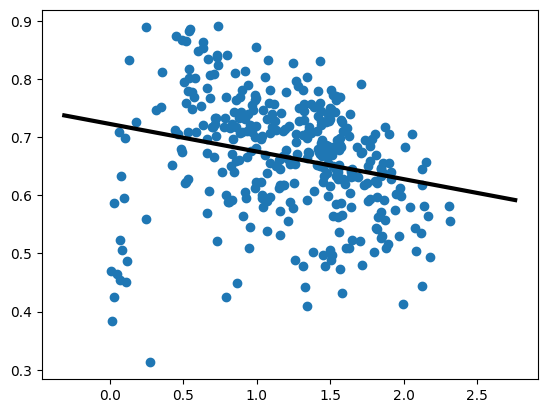

In [103]:
from sklearn.linear_model import LinearRegression
m = LinearRegression()
idx = np.logical_not((np.isnan(avg_stress2_score_ld.flatten())) | (np.isnan(scor_highvar_ct_ds[:,idx_ct_ordered].flatten())))
m.fit(avg_stress2_score_ld.flatten()[idx,None], scor_highvar_ct_ds[:,idx_ct_ordered].flatten()[idx])
pred_x = np.linspace(np.nanmin(avg_stress2_score_ld.flatten()), np.nanmax(avg_stress2_score_ld.flatten()), num=1000)[:,None]
pred_y = m.predict(pred_x)
plt.scatter(avg_stress2_score_ld.flatten()[idx], scor_highvar_ct_ds[:,idx_ct_ordered].flatten()[idx])
plt.plot(pred_x, pred_y, color='black', linewidth=3)
plt.savefig('plots/revision/scatter_sim2glycolysis-canonical_ld_highvar.pdf')

In [105]:
from scipy.stats import pearsonr
pearsonr(avg_stress2_score_ld.flatten()[idx], scor_highvar_ct_ds[:,idx_ct_ordered].flatten()[idx])

PearsonRResult(statistic=-0.2378048262655128, pvalue=4.916451904294398e-06)

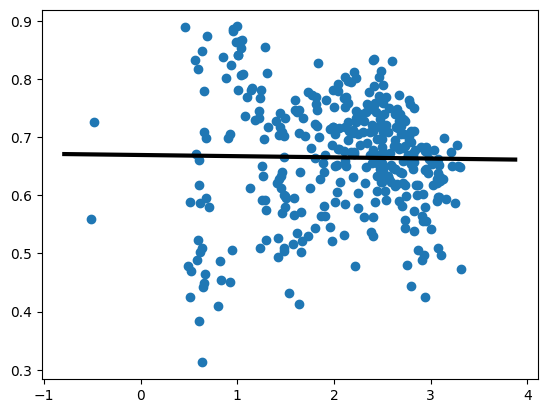

In [100]:
from sklearn.linear_model import LinearRegression
m = LinearRegression()
idx = np.logical_not((np.isnan(avg_electron_score_ld.flatten())) | (np.isnan(scor_highvar_ct_ds[:,idx_ct_ordered].flatten())))
m.fit(avg_electron_score_ld.flatten()[idx,None], scor_highvar_ct_ds[:,idx_ct_ordered].flatten()[idx])
pred_x = np.linspace(np.nanmin(avg_electron_score_ld.flatten()), np.nanmax(avg_electron_score_ld.flatten()), num=1000)[:,None]
pred_y = m.predict(pred_x)
plt.scatter(avg_electron_score_ld.flatten()[idx], scor_highvar_ct_ds[:,idx_ct_ordered].flatten()[idx])
plt.plot(pred_x, pred_y, color='black', linewidth=3)
plt.savefig('plots/revision/scatter_sim2electron_ld_highvar.pdf')

In [101]:
from scipy.stats import pearsonr
pearsonr(avg_electron_score_ld.flatten()[idx], scor_highvar_ct_ds[:,idx_ct_ordered].flatten()[idx])

PearsonRResult(statistic=-0.015263764929853966, pvalue=0.7725641029235313)

## TF vs. all genes

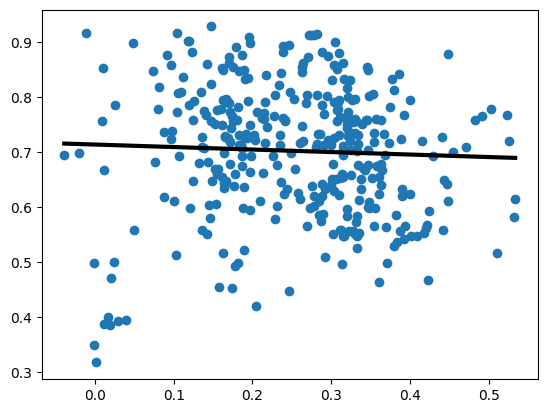

In [90]:
from sklearn.linear_model import LinearRegression
m = LinearRegression()
idx = np.logical_not((np.isnan(avg_stress_score_ld.flatten())) | (np.isnan(scor_highvar_TF_ct_ds[:,idx_ct_ordered].flatten())))
m.fit(avg_stress_score_ld.flatten()[idx,None], scor_highvar_TF_ct_ds[:,idx_ct_ordered].flatten()[idx])
pred_x = np.linspace(np.nanmin(avg_stress_score_ld.flatten()), np.nanmax(avg_stress_score_ld.flatten()), num=1000)[:,None]
pred_y = m.predict(pred_x)
plt.scatter(avg_stress_score_ld.flatten()[idx], scor_highvar_TF_ct_ds[:,idx_ct_ordered].flatten()[idx])
plt.plot(pred_x, pred_y, color='black', linewidth=3)
plt.savefig('plots/revision/scatter_sim2glycolysis_ld_highvarTF.pdf')

In [91]:
from scipy.stats import pearsonr
pearsonr(avg_stress_score_ld.flatten()[idx], scor_highvar_TF_ct_ds[:,idx_ct_ordered].flatten()[idx])

PearsonRResult(statistic=-0.04324680600911525, pvalue=0.41527850037597197)

In [95]:
from scipy.stats import pearsonr
pcc_glycolysis2sim_rand = pd.Series([ pearsonr(avg_stress_score_ld.flatten()[idx], scor[:,idx_ct_ordered].flatten()[idx]).statistic for scor in scor_highvar_rand_ct_ds ])
pcc_glycolysis2sim_rand.describe()

count    100.000000
mean      -0.125400
std        0.036726
min       -0.230809
25%       -0.142887
50%       -0.121286
75%       -0.105878
max       -0.050592
dtype: float64

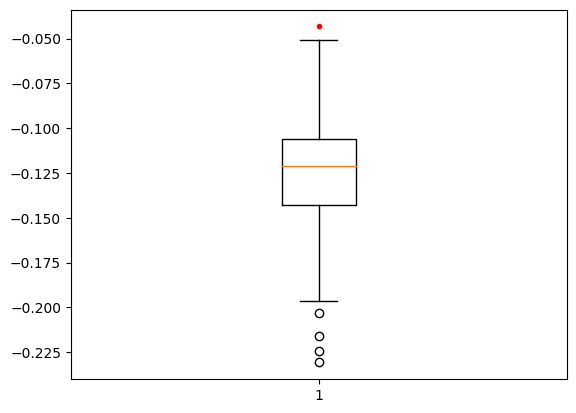

In [97]:
plt.boxplot(pcc_glycolysis2sim_rand)
plt.plot(1, -0.04324680600911525, 'r.')
plt.savefig('plots/revision/boxplot_sim2glycolysis_TF_vs_rand.pdf')

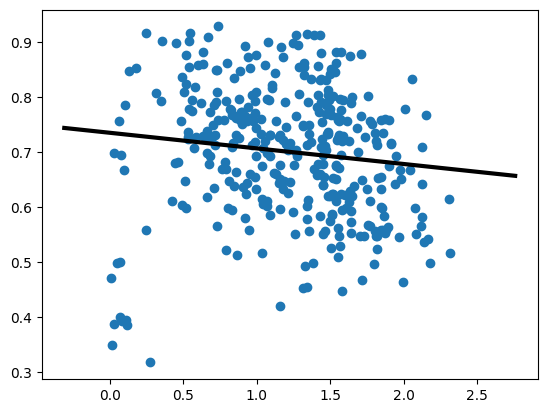

In [106]:
from sklearn.linear_model import LinearRegression
m = LinearRegression()
idx = np.logical_not((np.isnan(avg_stress2_score_ld.flatten())) | (np.isnan(scor_highvar_TF_ct_ds[:,idx_ct_ordered].flatten())))
m.fit(avg_stress2_score_ld.flatten()[idx,None], scor_highvar_TF_ct_ds[:,idx_ct_ordered].flatten()[idx])
pred_x = np.linspace(np.nanmin(avg_stress2_score_ld.flatten()), np.nanmax(avg_stress2_score_ld.flatten()), num=1000)[:,None]
pred_y = m.predict(pred_x)
plt.scatter(avg_stress2_score_ld.flatten()[idx], scor_highvar_TF_ct_ds[:,idx_ct_ordered].flatten()[idx])
plt.plot(pred_x, pred_y, color='black', linewidth=3)
plt.savefig('plots/revision/scatter_sim2glycolysis-canonical_ld_highvarTF.pdf')

In [108]:
from scipy.stats import pearsonr
pearsonr(avg_stress2_score_ld.flatten()[idx], scor_highvar_TF_ct_ds[:,idx_ct_ordered].flatten()[idx])

PearsonRResult(statistic=-0.12150662763433431, pvalue=0.020933517806312776)

In [107]:
from scipy.stats import pearsonr
pcc_glycolysis22sim_rand = pd.Series([ pearsonr(avg_stress2_score_ld.flatten()[idx], scor[:,idx_ct_ordered].flatten()[idx]).statistic for scor in scor_highvar_rand_ct_ds ])
pcc_glycolysis22sim_rand.describe()

count    100.000000
mean      -0.238996
std        0.035625
min       -0.364557
25%       -0.256178
50%       -0.235198
75%       -0.214256
max       -0.168386
dtype: float64

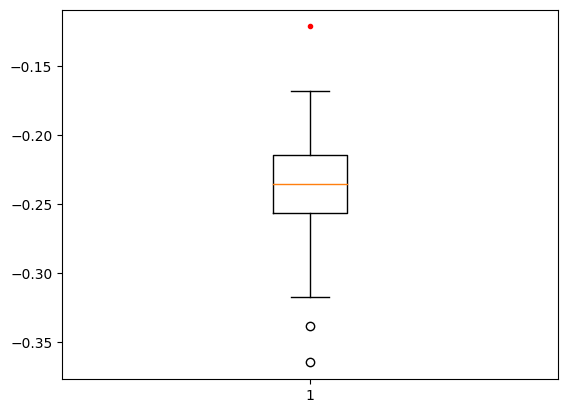

In [110]:
plt.boxplot(pcc_glycolysis22sim_rand)
plt.plot(1, -0.12150662763433431, 'r.')
plt.savefig('plots/revision/boxplot_sim2glycolysis-canonical_TF_vs_rand.pdf')

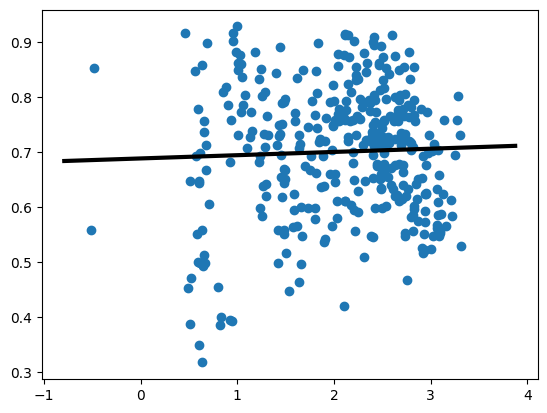

In [131]:
from sklearn.linear_model import LinearRegression
m = LinearRegression()
idx = np.logical_not((np.isnan(avg_electron_score_ld.flatten())) | (np.isnan(scor_highvar_TF_ct_ds[:,idx_ct_ordered].flatten())))
m.fit(avg_electron_score_ld.flatten()[idx,None], scor_highvar_TF_ct_ds[:,idx_ct_ordered].flatten()[idx])
pred_x = np.linspace(np.nanmin(avg_electron_score_ld.flatten()), np.nanmax(avg_electron_score_ld.flatten()), num=1000)[:,None]
pred_y = m.predict(pred_x)
plt.scatter(avg_electron_score_ld.flatten()[idx], scor_highvar_TF_ct_ds[:,idx_ct_ordered].flatten()[idx])
plt.plot(pred_x, pred_y, color='black', linewidth=3)
plt.savefig('plots/revision/scatter_sim2electron_transport_ld_highvarTF.pdf')

In [132]:
from scipy.stats import pearsonr
pearsonr(avg_electron_score_ld.flatten()[idx], scor_highvar_TF_ct_ds[:,idx_ct_ordered].flatten()[idx])

PearsonRResult(statistic=0.037933340215381035, pvalue=0.4724536716165922)

In [133]:
from scipy.stats import pearsonr
pcc_elecsim_rand = pd.Series([ pearsonr(avg_electron_score_ld.flatten()[idx], scor[:,idx_ct_ordered].flatten()[idx]).statistic for scor in scor_highvar_rand_ct_ds ])
pcc_elecsim_rand.describe()

count    100.000000
mean      -0.020313
std        0.042732
min       -0.113271
25%       -0.052221
50%       -0.027237
75%        0.006275
max        0.085043
dtype: float64

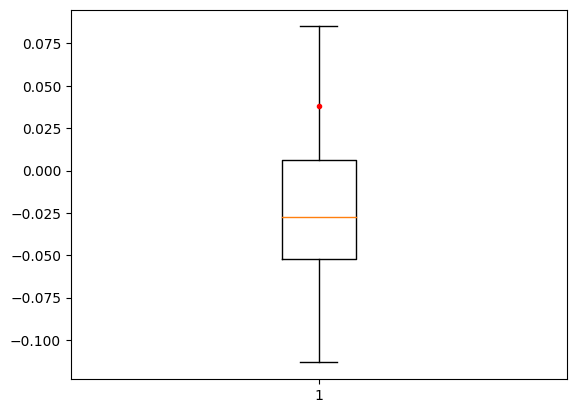

In [134]:
plt.boxplot(pcc_elecsim_rand)
plt.plot(1, 0.037933340215381035, 'r.')
plt.savefig('plots/revision/boxplot_sim2electron_TF_vs_rand.pdf')

# Stress on dataset-cell type average

In [455]:
[ len(np.intersect1d(adata_nsub.var_names, genes_glycolysis.symbol)), len(genes_glycolysis.symbol), adata_nsub.shape[1] ]

[9, 44, 3048]

In [456]:
shared_features_ref_bo = np.intersect1d(adata_ref.var_names, adata_bo.var_names)
len(shared_features_ref_bo)

22198

In [457]:
avg_expr_ref_ct.shape

(24, 22198)

In [458]:
avg_expr_bo_ct_ds_all = [ np.array([ np.array(adata_bo[(adata_bo.obs.annot_level_4 == x) & (adata_bo.obs.publication_protocol == ds),shared_features_ref_bo].X.mean(0)).flatten() if np.sum((adata_bo.obs.annot_level_4 == x) & (adata_bo.obs.publication_protocol == ds)) > 20 else np.repeat(-1, len(shared_features_ref_bo)) for x in ct2check]) for ds in adata_bo.obs.publication_protocol.cat.categories ]

In [459]:
expr_all = [np.log1p((np.exp(avg_expr_ref_ct)-1) * 100)] + avg_expr_bo_ct_ds_all
expr_all = np.concatenate(expr_all)
expr_all.shape

(888, 22198)

In [466]:
import re
meta = pd.DataFrame({'is_primary' : np.repeat([True,False],[avg_expr_ref_ct_highvar.shape[0], expr.shape[0]-avg_expr_ref_ct_highvar.shape[0]]),
                     'organoid_dataset' : np.repeat(['']+list(adata_bo.obs.publication_protocol.cat.categories), avg_expr_ref_ct_highvar.shape[0]),
                     'neuron_region' : np.tile([re.sub(r' Neuron.+','',x).replace('llar','llum').replace('phalic','phalon').replace('lamic','lamus') for x in ct2check], len(avg_expr_bo_ct_ds_all)+1),
                     'neuron_ntt' : np.tile([re.sub(r'^.+ Neuron ','',x) for x in ct2check], len(avg_expr_bo_ct_ds_all)+1),
                     'neuron_subtype' : np.tile(ct2check, len(avg_expr_bo_ct_ds_all)+1)})

idx_datasets_ordered = [14,11,12,25,30,33,20,15,32,4,31,19,6,16,26,35,29,7,22,2,3,
                        5,18,24,13,34,8,9,10,27,28,0,1,23,21,17]
ordered_datasets_type = np.repeat(['unguided','guided'], [5,len(idx_datasets_ordered)-5])
ordered_datasets_target = np.repeat(['','cortex','subcortex','hypothalamus','thalamus','midbrain','cerebellum','medulla','choroid plexus','oligo'],[5,16,3,1,1,5,1,2,1,1])
idx_entries = np.repeat(np.array(idx_datasets_ordered)+1, avg_expr_ref_ct_highvar.shape[0]) * avg_expr_ref_ct_highvar.shape[0] + np.tile(np.arange(avg_expr_ref_ct_highvar.shape[0]), len(avg_expr_bo_ct_ds_all))
meta['protocol_type'] = ""
meta.iloc[idx_entries,np.where(meta.columns == 'protocol_type')[0]] = np.repeat(ordered_datasets_type, avg_expr_ref_ct_highvar.shape[0])
meta['protocol_target'] = ""
meta.iloc[idx_entries,np.where(meta.columns == 'protocol_target')[0]] = np.repeat(ordered_datasets_target, avg_expr_ref_ct_highvar.shape[0])
meta['available'] = (expr < 0).sum(1) == 0
meta.head()

is_primary organoid_dataset    neuron_region neuron_ntt  \
0        True                        Cerebellum    NT-GABA   
1        True                        Cerebellum     NT-GLY   
2        True                        Cerebellum   NT-VGLUT   
3        True                   Dorsal Midbrain    NT-GABA   
4        True                   Dorsal Midbrain   NT-VGLUT   

                    neuron_subtype protocol_type protocol_target  available  
0        Cerebellar Neuron NT-GABA                                     True  
1         Cerebellar Neuron NT-GLY                                     True  
2       Cerebellar Neuron NT-VGLUT                                     True  
3   Dorsal Midbrain Neuron NT-GABA                                     True  
4  Dorsal Midbrain Neuron NT-VGLUT                                     True

In [467]:
meta.tail()

is_primary                                         organoid_dataset  \
883       False  Yoon, 2019: Yoon, 2019 (doi: 10.1038/s41592-018-0255-0)   
884       False  Yoon, 2019: Yoon, 2019 (doi: 10.1038/s41592-018-0255-0)   
885       False  Yoon, 2019: Yoon, 2019 (doi: 10.1038/s41592-018-0255-0)   
886       False  Yoon, 2019: Yoon, 2019 (doi: 10.1038/s41592-018-0255-0)   
887       False  Yoon, 2019: Yoon, 2019 (doi: 10.1038/s41592-018-0255-0)   

             neuron_region neuron_ntt                        neuron_subtype  \
883               Thalamus   NT-VGLUT              Thalamic Neuron NT-VGLUT   
884       Ventral Midbrain    NT-GABA       Ventral Midbrain Neuron NT-GABA   
885       Ventral Midbrain     NT-GLY        Ventral Midbrain Neuron NT-GLY   
886       Ventral Midbrain   NT-VGLUT      Ventral Midbrain Neuron NT-VGLUT   
887  Ventral Telencephalon    NT-GABA  Ventral Telencephalic Neuron NT-GABA   

    protocol_type protocol_target  available  
883        guided          cortex       True  
884        guided          cortex      False  
885        guided          cortex      False  
886        guided          cortex      False  
887        guided          cortex       True

In [494]:
adata_nsub_all = ad.AnnData(X=expr_all, obs=meta, var=pd.DataFrame({'symbol' : shared_features_ref_bo}, index = shared_features_ref_bo))
adata_nsub_all = adata_nsub_all[adata_nsub_all.obs.available,:]
adata_nsub_all.layers['lognorm'] = adata_nsub_all.X.copy()

/local1/scratch/hezhi/temp/ipykernel_54971/1646715493.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_nsub_all = ad.AnnData(X=expr_all, obs=meta, var=pd.DataFrame({'symbol' : shared_features_ref_bo}, index = shared_features_ref_bo))
/links/groups/treutlein/USERS/zhisong_he/anaconda3/envs/env_reticulate/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [495]:
sc.pp.scale(adata_nsub_all)
adata_nsub_all.layers['scaled'] = adata_nsub_all.X.copy()

In [496]:
adata_nsub_all.shape

(457, 22198)

In [470]:
[ len(np.intersect1d(adata_nsub_all.var_names, genes_glycolysis.symbol)), len(genes_glycolysis.symbol), adata_nsub_all.shape[1] ]

[44, 44, 22198]

In [497]:
adata_nsub_all.X = adata_nsub_all.layers['scaled'].copy()

In [498]:
sc.tl.score_genes(adata_nsub_all, genes_glycolysis['symbol'], score_name='score_glycolysis')

/links/groups/treutlein/USERS/zhisong_he/anaconda3/envs/env_reticulate/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [499]:
glycolysis_scores_ct_ds = np.array([ np.array([ adata_nsub_all.obs.loc[(adata_nsub_all.obs.organoid_dataset == ds) & (adata_nsub_all.obs.neuron_subtype == ct),'score_glycolysis'][0]
                                               if np.sum((adata_nsub_all.obs.organoid_dataset == ds) & (adata_nsub_all.obs.neuron_subtype == ct)) > 0 else np.nan
                                               for ct in neuron_subtypes[neuron_subtypes.str.match('.+NT\\-(VGLUT|GABA)')] ])
                                    for ds in list(adata_bo.obs.publication_protocol.cat.categories)+[''] ])

In [559]:
np.nanpercentile(glycolysis_scores_ct_ds, 95)

0.38168596078977673

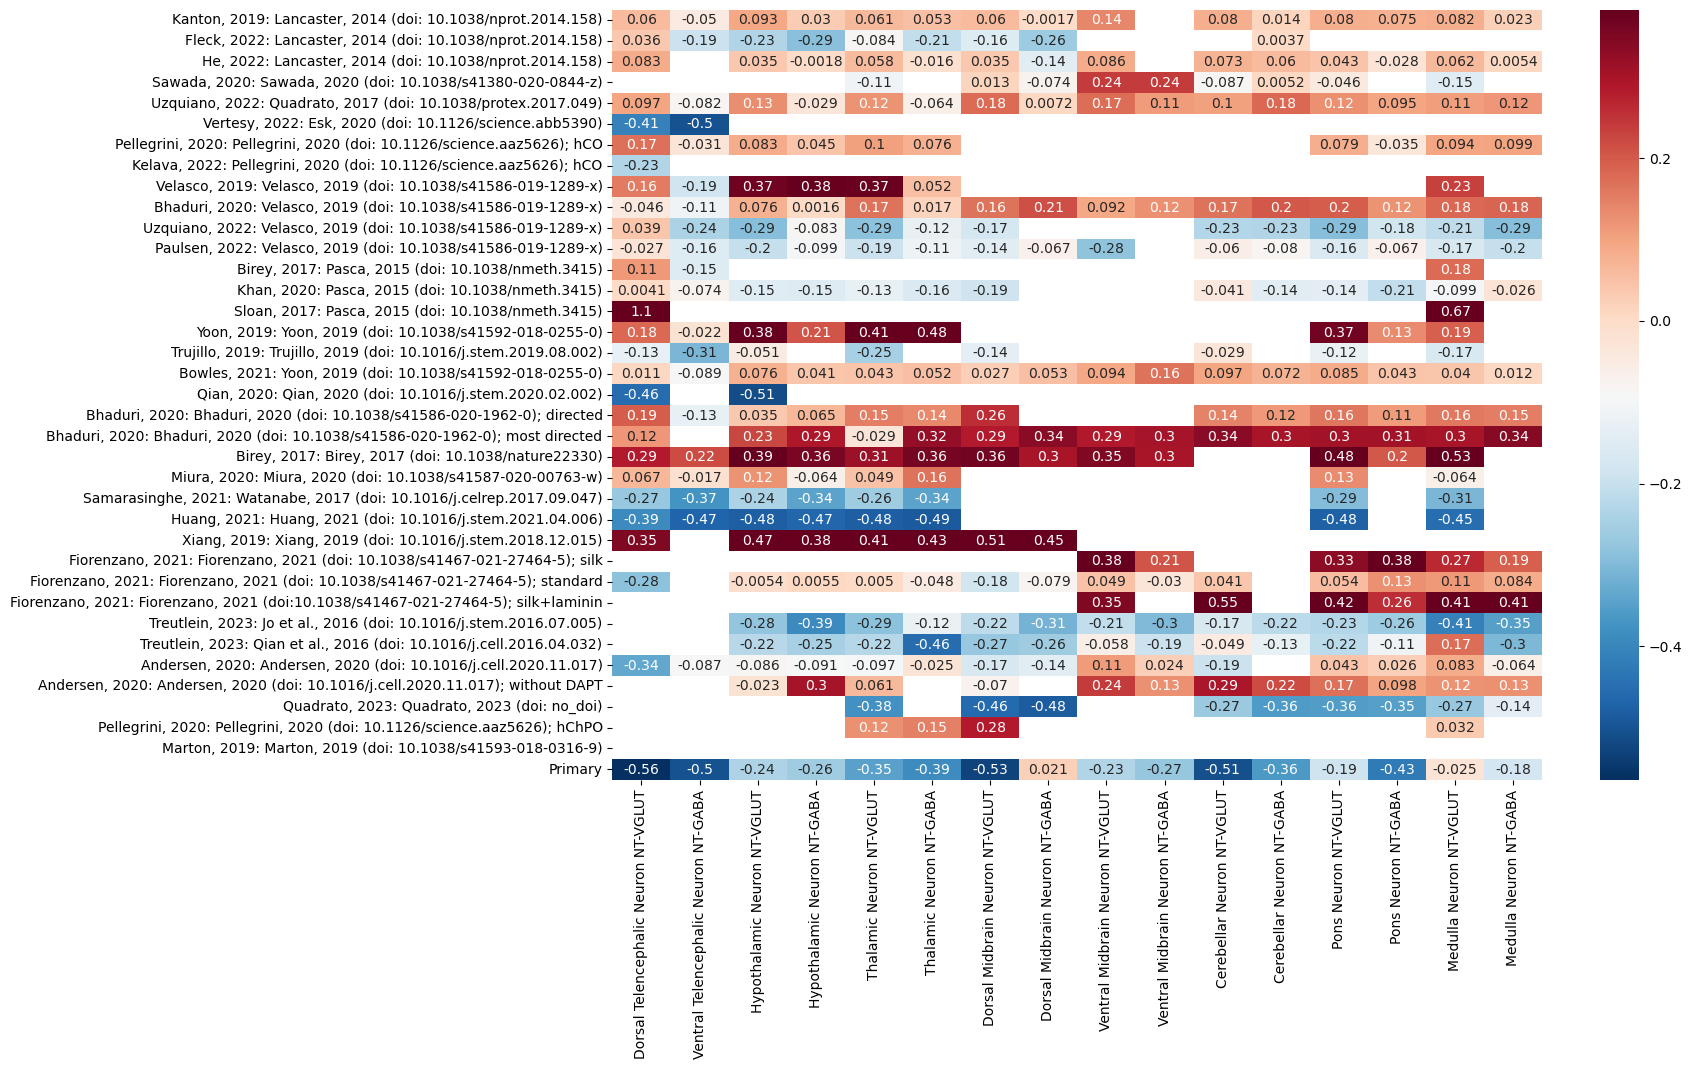

In [570]:
import seaborn as sns
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (15, 10)}):
    sns.heatmap(pd.DataFrame(glycolysis_scores_ct_ds,
                             index=list(adata_bo.obs.publication_protocol.cat.categories)+['Primary']).set_axis(neuron_subtypes[neuron_subtypes.str.match('.+NT\\-(VGLUT|GABA)')], axis=1).iloc[idx_datasets_ordered+[36],:], annot=True, cmap='RdBu_r', fmt='.02', vmax=np.nanpercentile(glycolysis_scores_ct_ds, 95))

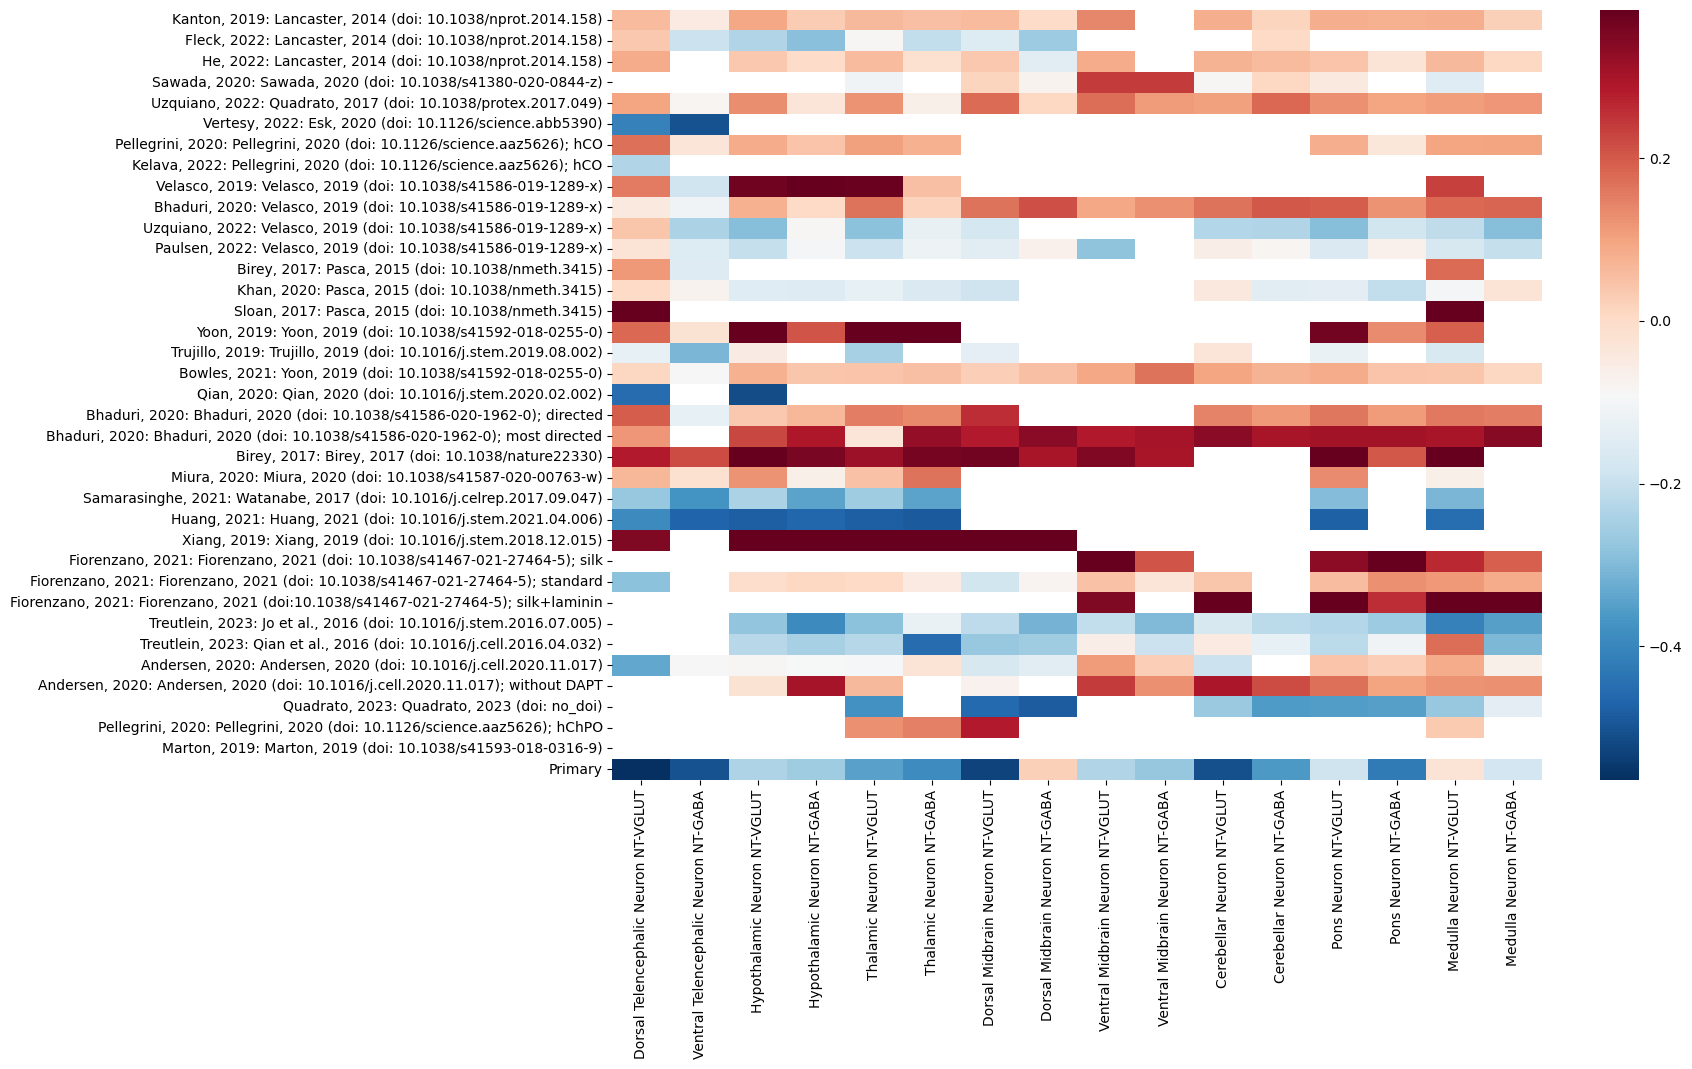

In [555]:
import seaborn as sns
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (15, 10)}):
    sns.heatmap(pd.DataFrame(glycolysis_scores_ct_ds,
                             index=list(adata_bo.obs.publication_protocol.cat.categories)+['Primary']).set_axis(neuron_subtypes[neuron_subtypes.str.match('.+NT\\-(VGLUT|GABA)')], axis=1).iloc[idx_datasets_ordered+[36],:], annot=False, cmap='RdBu_r', vmax=np.nanpercentile(glycolysis_scores_ct_ds, 95))
    plt.savefig('plots/phase3_final_0516/heatmap_glycolysis_ct.pdf')

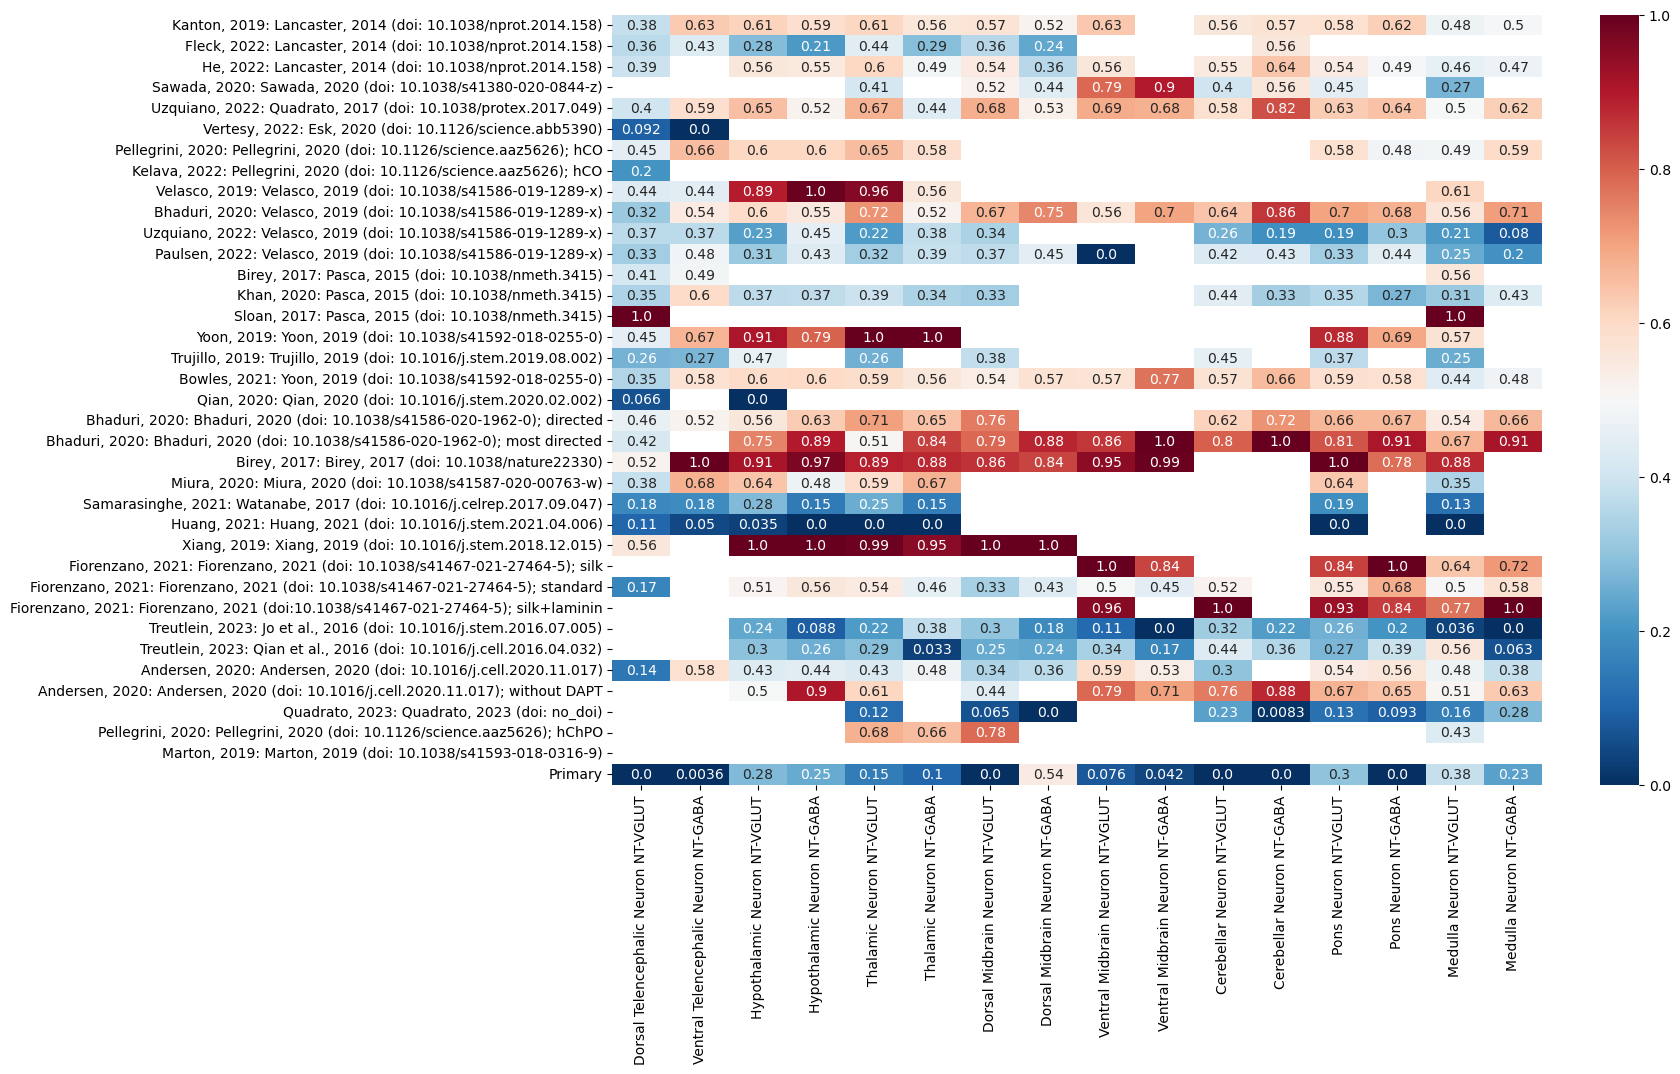

In [546]:
mat = glycolysis_scores_ct_ds
mat = np.apply_along_axis(lambda x: (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x)), 0, mat)
import seaborn as sns
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (15, 10)}):
    sns.heatmap(pd.DataFrame(mat,
                             index=list(adata_bo.obs.publication_protocol.cat.categories)+['Primary']).set_axis(neuron_subtypes[neuron_subtypes.str.match('.+NT\\-(VGLUT|GABA)')], axis=1).iloc[idx_datasets_ordered+[36],:], annot=True, cmap='RdBu_r', fmt='.02')

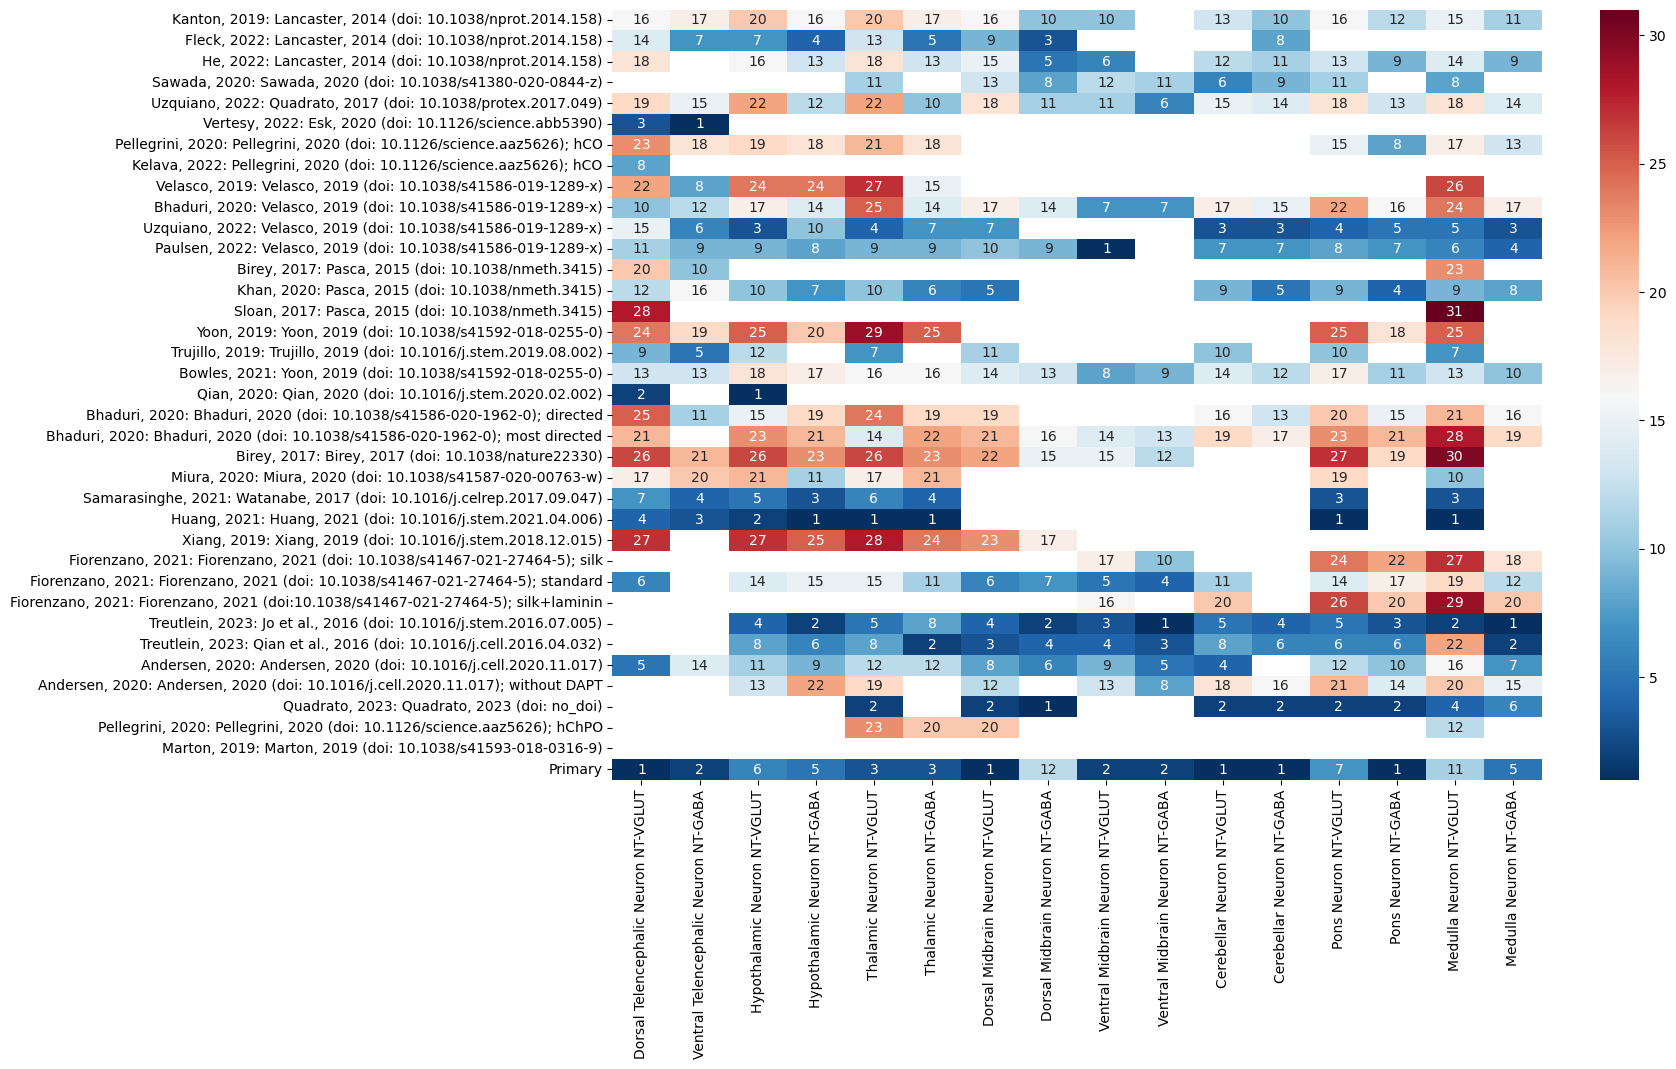

In [554]:
from scipy.stats import rankdata
mat = glycolysis_scores_ct_ds
mat = rankdata(mat, axis=0, method='min').astype('float32')
mat[np.isnan(glycolysis_scores_ct_ds)] = np.nan

import seaborn as sns
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (15, 10)}):
    sns.heatmap(pd.DataFrame(mat,
                             index=list(adata_bo.obs.publication_protocol.cat.categories)+['Primary']).set_axis(neuron_subtypes[neuron_subtypes.str.match('.+NT\\-(VGLUT|GABA)')], axis=1).iloc[idx_datasets_ordered+[36],:], annot=True, cmap='RdBu_r')

In [537]:
from scipy.stats import spearmanr
spearmanr(glycolysis_scores_ct_ds[:36,:].flatten(), avg_stress_score.flatten(), nan_policy='omit')

SpearmanrResult(correlation=0.897902025982228, pvalue=1.2412299823830668e-124)

In [538]:
from scipy.stats import spearmanr
spearmanr(glycolysis_scores_ct_ds[:36,:].flatten(), avg_stress_score_scaled.flatten(), nan_policy='omit')

SpearmanrResult(correlation=0.908007529443121, pvalue=5.013673249038172e-132)

In [574]:
from scipy.stats import spearmanr
spearmanr(glycolysis_scores_ct_ds[:36,:].flatten(), scor_highvar_ct_ds[:,idx_ct_ordered].flatten(), nan_policy='omit')

SpearmanrResult(correlation=-0.443218265169198, pvalue=8.577047932643823e-18)

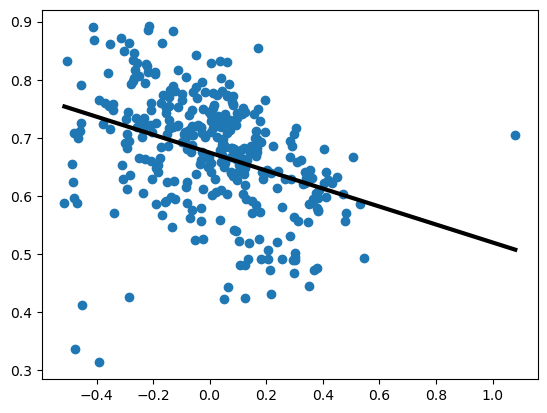

In [585]:
from sklearn.linear_model import LinearRegression
m = LinearRegression()
idx = np.logical_not((np.isnan(glycolysis_scores_ct_ds[:36,:].flatten())) | (np.isnan(scor_highvar_ct_ds[:,idx_ct_ordered].flatten())))
m.fit(glycolysis_scores_ct_ds[:36,:].flatten()[idx,None], scor_highvar_ct_ds[:,idx_ct_ordered].flatten()[idx])
pred_x = np.linspace(np.nanmin(glycolysis_scores_ct_ds[:36,:].flatten()), np.nanmax(glycolysis_scores_ct_ds[:36,:].flatten()), num=1000)[:,None]
pred_y = m.predict(pred_x)
plt.scatter(glycolysis_scores_ct_ds[:36,:].flatten()[idx], scor_highvar_ct_ds[:,idx_ct_ordered].flatten()[idx])
plt.plot(pred_x, pred_y, color='black', linewidth=3)
plt.savefig('plots/phase3_final_0516/scatter_sim2glycolysis.pdf')

In [587]:
from scipy.stats import pearsonr
pearsonr(glycolysis_scores_ct_ds[:36,:].flatten()[idx], scor_highvar_ct_ds[:,idx_ct_ordered].flatten()[idx])

PearsonRResult(statistic=-0.3644173979755974, pvalue=4.071347112155479e-12)